In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import re
import os
import datetime
import geopandas as gpd
import rasterio
from PIL import Image
import seaborn as sns
from shapely.geometry import Point, Polygon
import random
from mpl_toolkits.mplot3d import Axes3D
!pip install ipympl

pd.set_option("display.max_rows",100)
pd.set_option("display.max_columns", 100)
pd.set_option("display.width",1000)

## Reading the Dataset

In [2]:
with open("/kaggle/input/seismic-shocks-of-nepal-earthquake-dataset/earthquake_info.txt", "r") as file:
    ## Reading each lines in the file
    data = file.readlines()
    
earthquake_data = []

for line in data[6:]:##upon validating the text file, the useful text starts from 6th position
    parts = line.strip().split()
    if "AM" or "PM" in parts:##checking if am, pm present in the splitted parts
        for element in parts:
            if element in ["AM", "PM"]:
                parts[1] = f"{parts [1]} {element}"
    parts = [element for element in parts if element not in ["AM", "PM"]]
                
                
            
    
    if len(parts)>=5:
        date, time, lat, long, mag = parts[:5]
        epicenter = " ".join(parts[5:]) if len(parts)>5 else ""##some of the epicenters are seprated by hyphen so needed this step
        
        earthquake_data.append({"Date": date, 
                                "Time": time, 
                                "Latitute": lat,
                                "Longitude": long,
                                "Magnitude": mag,
                                "Epicenter": epicenter
                               })

In [3]:
earthquake_df = pd.DataFrame(earthquake_data)
earthquake_df.head()

Date   Time Latitute Longitude Magnitude Epicenter
0  2023-11-05  08:39    28.91     82.20       4.1  Jajarkot
1  2023-11-04  19:37    28.88     82.20       4.0  Jajarkot
2  2023-11-04  09:55    28.94     82.24       4.2  Jajarkot
3  2023-11-03  22:31    28.92     82.26       4.6  Jajarkot
4  2023-11-03  18:50    28.88     82.20       4.3  Jajarkot

In [4]:
earthquake_df[earthquake_df["Date"]=="2015-05-03"]

Date      Time Latitute Longitude Magnitude       Epicenter
641  2015-05-03   3:29 AM    27.69     85.93       4.5  Sindhupalchowk
642  2015-05-03     10:46    27.94     84.83       4.5         Dhading
643  2015-05-03  10:39 PM    28.05     84.94         4         Dhading
644  2015-05-03     08:27    28.09     85.72       4.2  Sindhupalchowk
645  2015-05-03     08:00    27.98     84.87       4.1         Dhading
646  2015-05-03     06:58    27.89     85.73         4  Sindhupalchowk
647  2015-05-03     05:47    28.08     85.04         4          Gorkha
648  2015-05-03     05:20     27.8     85.11       4.9         Nuwakot

## Data Wrangling

In [5]:
def time_24hr_format(time_str):
    if time_str == "N/A":
        return np.nan
    else:
        try:
            #Check if AM/ PM is present to convert into 24 hr format
            time_obj = datetime.datetime.strptime(time_str,"%I:%M %p")
            return time_obj.strftime("%H:%M")##converting time to hour:minute format
        except ValueError:
            return time_str
        

In [6]:
earthquake_df["Time"] = earthquake_df["Time"].apply(time_24hr_format)

In [7]:
earthquake_df["Date"] = pd.to_datetime(earthquake_df["Date"])
earthquake_df["Time"] = pd.to_datetime(earthquake_df["Time"], format = "%H:%M").dt.time
earthquake_df.head()

Date      Time Latitute Longitude Magnitude Epicenter
0 2023-11-05  08:39:00    28.91     82.20       4.1  Jajarkot
1 2023-11-04  19:37:00    28.88     82.20       4.0  Jajarkot
2 2023-11-04  09:55:00    28.94     82.24       4.2  Jajarkot
3 2023-11-03  22:31:00    28.92     82.26       4.6  Jajarkot
4 2023-11-03  18:50:00    28.88     82.20       4.3  Jajarkot

In [8]:
earthquake_df["Latitute"] = earthquake_df["Latitute"].astype("float")
earthquake_df["Longitude"] = earthquake_df["Longitude"].astype("float")
earthquake_df["Magnitude"] = earthquake_df["Magnitude"].astype("float")


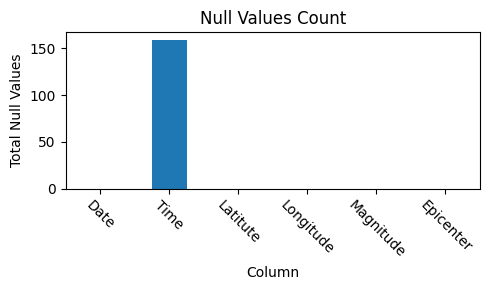

In [9]:
plt.figure(figsize = (5,3))
ax = earthquake_df.isnull().sum().plot(kind = "bar")
plt.title("Null Values Count")
plt.xlabel("Column")
plt.ylabel("Total Null Values")

ax.set_xticklabels(ax.get_xticklabels(), rotation = -45)
plt.tight_layout()

**Setting all the null values in time column as NG: Not Given**

In [10]:
earthquake_df.fillna(value = "NG", axis = 0, inplace = True)##filling null values
earthquake_df.isnull().sum()

Date         0
Time         0
Latitute     0
Longitude    0
Magnitude    0
Epicenter    0
dtype: int64

In [11]:
earthquake_df.tail()

Date      Time  Latitute  Longitude  Magnitude       Epicenter
1090 2000-03-13        NG    27.730     87.710        5.1   Sankhuwasabha
1091 2000-03-13        NG    29.770     81.410        4.2         Bajhang
1092 2000-02-26        NG    28.617     82.314        5.1        Jajarkot
1093 2000-01-25  12:07:00    27.378     88.059        4.6       Taplejung
1094 2000-01-20        NG    27.928     86.060        4.8  Sindhupalchowk

## Feature Engineering

In [12]:
earthquake_df_new = earthquake_df.copy(deep = True)

## Extracting Year, Month and Day from Date
earthquake_df_new["Year"] = earthquake_df_new["Date"].dt.year
earthquake_df_new["Month"] = earthquake_df_new["Date"].dt.strftime("%B")
earthquake_df_new["Day"] = earthquake_df_new["Date"].dt.strftime("%A")
earthquake_df_new.head()

Date      Time  Latitute  Longitude  Magnitude Epicenter  Year     Month       Day
0 2023-11-05  08:39:00     28.91      82.20        4.1  Jajarkot  2023  November    Sunday
1 2023-11-04  19:37:00     28.88      82.20        4.0  Jajarkot  2023  November  Saturday
2 2023-11-04  09:55:00     28.94      82.24        4.2  Jajarkot  2023  November  Saturday
3 2023-11-03  22:31:00     28.92      82.26        4.6  Jajarkot  2023  November    Friday
4 2023-11-03  18:50:00     28.88      82.20        4.3  Jajarkot  2023  November    Friday

In [13]:
## Creating Points from the Latitude Longtitude Column
earthquake_df_new["Geometry"] = earthquake_df_new.apply(lambda x: Point(x["Latitute"], x["Longitude"]), axis = 1)
earthquake_df_new.head()

/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:130: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Date      Time  Latitute  Longitude  Magnitude Epicenter  Year     Month       Day             Geometry
0 2023-11-05  08:39:00     28.91      82.20        4.1  Jajarkot  2023  November    Sunday   POINT (28.91 82.2)
1 2023-11-04  19:37:00     28.88      82.20        4.0  Jajarkot  2023  November  Saturday   POINT (28.88 82.2)
2 2023-11-04  09:55:00     28.94      82.24        4.2  Jajarkot  2023  November  Saturday  POINT (28.94 82.24)
3 2023-11-03  22:31:00     28.92      82.26        4.6  Jajarkot  2023  November    Friday  POINT (28.92 82.26)
4 2023-11-03  18:50:00     28.88      82.20        4.3  Jajarkot  2023  November    Friday   POINT (28.88 82.2)

In [14]:
## Converting Normal Dataframe to GeoDataFrame to get Geological Access
earthquake_df_new = gpd.GeoDataFrame(earthquake_df_new, geometry="Geometry")
earthquake_df_new.head()

Date      Time  Latitute  Longitude  Magnitude Epicenter  Year     Month       Day                   Geometry
0 2023-11-05  08:39:00     28.91      82.20        4.1  Jajarkot  2023  November    Sunday  POINT (28.91000 82.20000)
1 2023-11-04  19:37:00     28.88      82.20        4.0  Jajarkot  2023  November  Saturday  POINT (28.88000 82.20000)
2 2023-11-04  09:55:00     28.94      82.24        4.2  Jajarkot  2023  November  Saturday  POINT (28.94000 82.24000)
3 2023-11-03  22:31:00     28.92      82.26        4.6  Jajarkot  2023  November    Friday  POINT (28.92000 82.26000)
4 2023-11-03  18:50:00     28.88      82.20        4.3  Jajarkot  2023  November    Friday  POINT (28.88000 82.20000)

In [15]:
earthquake_df_new.dtypes

Date         datetime64[ns]
Time                 object
Latitute            float64
Longitude           float64
Magnitude           float64
Epicenter            object
Year                  int32
Month                object
Day                  object
Geometry           geometry
dtype: object

In [16]:
earthquake_df_new["Normalized_Epicenter"] = earthquake_df_new["Epicenter"].str.strip().str.lower()
grouped_epicenter = earthquake_df_new.groupby("Normalized_Epicenter")["Epicenter"].unique()

In [17]:
for grp, names in grouped_epicenter.items():
    print(names)

['Achham']
['Amjilesa, Taplejung']
['Arghanchi']
['Around Kanchanjunga']
['Baglung']
['Baitadi']
['Bajhang']
['Bajhang and Doti border']
['Bajhang-Bajura border']
['Bajhang-Darchula border']
['Bajhang/Bajura']
['Bajhang/Humla border']
['Bajura']
['Bajura/Humla']
['Bangaladesh']
['Bangladesh']
['Banke']
['Bhaktapur']
['Bhojpur']
['Bhojpur-Sankhuwasabha border']
['Bhuj/India']
['Bhutan']
['Binnaguri, India']
['Brahmajali, Bhajhang']
['Dailekh']
['Darchula']
['Darchula - India Border']
['Darchula(Nepal-India Border)']
['Darkha, Dhading']
['Dhading']
['Dhankuta']
['Dhanusa']
['Dhanusha']
['Dharchula']
['Dolakha']
['Dolpa']
['Doti']
['East Rukum']
['Ghalegaun, Kaski']
['Gorkha' 'gorkha']
['Gorkha/Dhading']
['Gorkha/Lamjung border']
['Humla']
['Humla/Mugu']
['Illam']
['India']
['India (close to Darchula)']
['Isabun,Terathum']
['Jajarkot']
['Jhapa-India Border Region']
['Jumla']
['Kabre']
['Kailali']
['Kalikot']
['Kanchanpur']
['Karkigaun-Jajarkot']
['Kaseri, Rasuwa']
['Kaski']
['Kathmandu']


**Correcting the Epicenter Names**

In [18]:
to_correct = {"Bangaladesh": "Bangladesh", 
              "Dhanusa": "Dhanusha",
              "Kavrepalanchok": "Kavre",
              "Kavrepalanchowk": "Kavre",
              "Sindhupalchok": "Sindhupalchowk",
              "Listikot, Sindhupalchok": "Listikot, Sindhupalchowk",
              "Nepal India Border": "Nepal-India Border",
              "Northern part of Bajura": "Northern Bajura",
              "Rolpa - Rukum border region": "Rolpa-Rukum border region",
              "Sankhuwasava": "Sankhuwasabha",
              "Sidhupalchowk": "Sindhupalchowk",
              "Sindupalchok": "Sindhupalchowk",
              "Sindupalchowk": "Sindhupalchowk",
              "Lalitput": "Lalitpur",
              "Nagpa, Dolakaha": "Nagpa, Dolakha"}

In [19]:
earthquake_df_new["Epicenter"] = earthquake_df_new["Epicenter"].str.title().replace(to_correct)

In [20]:
earthquake_df_new.drop("Normalized_Epicenter", axis = 1, inplace = True)
earthquake_df_new.head()

Date      Time  Latitute  Longitude  Magnitude Epicenter  Year     Month       Day                   Geometry
0 2023-11-05  08:39:00     28.91      82.20        4.1  Jajarkot  2023  November    Sunday  POINT (28.91000 82.20000)
1 2023-11-04  19:37:00     28.88      82.20        4.0  Jajarkot  2023  November  Saturday  POINT (28.88000 82.20000)
2 2023-11-04  09:55:00     28.94      82.24        4.2  Jajarkot  2023  November  Saturday  POINT (28.94000 82.24000)
3 2023-11-03  22:31:00     28.92      82.26        4.6  Jajarkot  2023  November    Friday  POINT (28.92000 82.26000)
4 2023-11-03  18:50:00     28.88      82.20        4.3  Jajarkot  2023  November    Friday  POINT (28.88000 82.20000)

### Extracting Data

In [21]:
## Extracting dataframe without NG and with NG in Time column into separate Dataframe
earthquake_df_ng = earthquake_df_new[earthquake_df_new["Time"]=="NG"]
earthquake_df_without_ng = earthquake_df_new[earthquake_df_new["Time"]!="NG"]

In [22]:
## Extracting time of the day for without ng dataframe
earthquake_df_without_ng["Time_of_Day"] = pd.to_datetime(earthquake_df_without_ng["Time"], format = "%H:%M:%S").apply(
    lambda x:"Morning" if 5<=x.hour<12 else
    "Afternoon" if 12<=x.hour<17 else
    "Evening" if 17<=x.hour<21 else
    "Night")


/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


#### Plotting the Geographical Map of Nepal

#### Reading the First Mosaic Part

In [23]:
# file1= rasterio.open("/kaggle/input/map-of-nepal/10n060e_20101117_gmted_mea075.tif")
# dataset1 = file1.read()
# dataset1.shape

In [24]:
file= rasterio.open("/kaggle/input/map-of-nepal/gt30e060n40.tif")
dataset = file.read()
dataset.shape

(1, 6000, 4800)

### Read the second Mosaic Part

In [25]:
# file2 = rasterio.open("/kaggle/input/map-of-nepal/30n060e_20101117_gmted_mea075.tif")
# dataset2 = file2.read()
# dataset2.shape

#### Combining Both Datasets to One

In [26]:
# from rasterio.merge import merge
# src_to_mosaic = []
# src_to_mosaic.append(file1)
# src_to_mosaic.append(file2)
# mosaic, out_trans = merge(src_to_mosaic)

In [27]:
# ## Extracting Metadata of the source file
# output_meta = file1.meta.copy()
# output_meta

In [28]:
# ## Updating the metadata
# output_meta.update({"height": mosaic.shape[1], 
#                    "width": mosaic.shape[2],
#                   "transform": out_trans
#                    }
#                   )

In [29]:
# ## Saving the mosaic to disc
# output_path = "./nepal_mosaic.tif"
# with rasterio.open(output_path, "w", **output_meta) as dest:
#     dest.write(mosaic)
    
# file_mosaic = rasterio.open(output_path)
# data_mosaic = file_mosaic.read()
# data_mosaic.shape
    

In [30]:
# plt.imshow(data_mosaic[0], cmap = "ocean_r")
# plt.axis("off")
# plt.show()

In [31]:
from shapely.geometry import mapping
from rasterio import mask as msk

In [32]:
shp_file = gpd.read_file("/kaggle/input/map-of-nepal/world-administrative-boundaries.shp")
shp_file.head()

iso3        status color_code                        name continent         region iso_3166_1_ french_shor                                           geometry
0  IRN  Member State        IRN  Iran (Islamic Republic of)      Asia  Southern Asia          IR        Iran  MULTIPOLYGON (((55.73499 26.83805, 55.73166 26...
1  LKA  Member State        LKA                   Sri Lanka      Asia  Southern Asia          LK   Sri Lanka  MULTIPOLYGON (((79.91180 9.02014, 79.89499 8.9...
2  PAK  Member State        PAK                    Pakistan      Asia  Southern Asia          PK    Pakistan  POLYGON ((75.32261 32.32444, 75.32654 32.30044...
3  MDV  Member State        MDV                    Maldives      Asia  Southern Asia          MV    Maldives  MULTIPOLYGON (((73.10942 -0.62000, 73.11519 -0...
4  IND  Member State        IND                       India      Asia  Southern Asia          IN        Inde  MULTIPOLYGON (((93.89941 6.80708, 93.82707 6.7...

In [33]:
nepal_df = shp_file[shp_file["name"] == "Nepal"]
nepal_df.head()

iso3        status color_code   name continent         region iso_3166_1_ french_shor                                           geometry
6  NPL  Member State        NPL  Nepal      Asia  Southern Asia          NP       Népal  POLYGON ((88.14279 27.86605, 88.15248 27.86416...

In [34]:
# ## Focusing just on Nepal by masking other areas
# clipped_array, clipped_transform = msk.mask(file_mosaic, shapes = [mapping(nepal_df.iloc[0].geometry)], crop = True)
# clipped_array

In [35]:
## Focusing just on Nepal by masking other areas
clipped_array, clipped_transform = msk.mask(file, shapes = [mapping(nepal_df.iloc[0].geometry)], crop = True)
clipped_array

array([[[-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        ...,
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999]]], dtype=int16)

In [36]:
## Investigating the no data value
nodata_values = file.nodata
print(f"The no data values is {nodata_values}")

The no data values is -9999.0


In [37]:
## Change the nodata value to more than the maximum elevation
def clip_raster(gdf, img):
    """
    This is a function used to replace the no data value
    with a meaning value.
    
    Input:
    
    gdf: A Geographical Dataframe
    img: a dataset object opened in 'r' mode.
    Raster to which the mask will be applied.
    
    Output:
    Returns the clipped array and the value range for the plot
    """
    clipped_array, clipped_transform = msk.mask(img, 
                                                shapes = [mapping(gdf.iloc[0].geometry)], 
                                                crop = True)
    clipped_array, clipped_transform = msk.mask(img, 
                                                shapes = [mapping(gdf.iloc[0].geometry)], 
                                                crop = True,nodata = np.amax(clipped_array[0])+1)
    clipped_array[0] = clipped_array[0] + abs(np.amin(clipped_array))
    value_range = np.amax(clipped_array) + abs(np.amin(clipped_array))
    return clipped_array, value_range

nepal_topography, value_range = clip_raster(nepal_df, file)

In [38]:
nepal_topography.shape

(1, 487, 978)

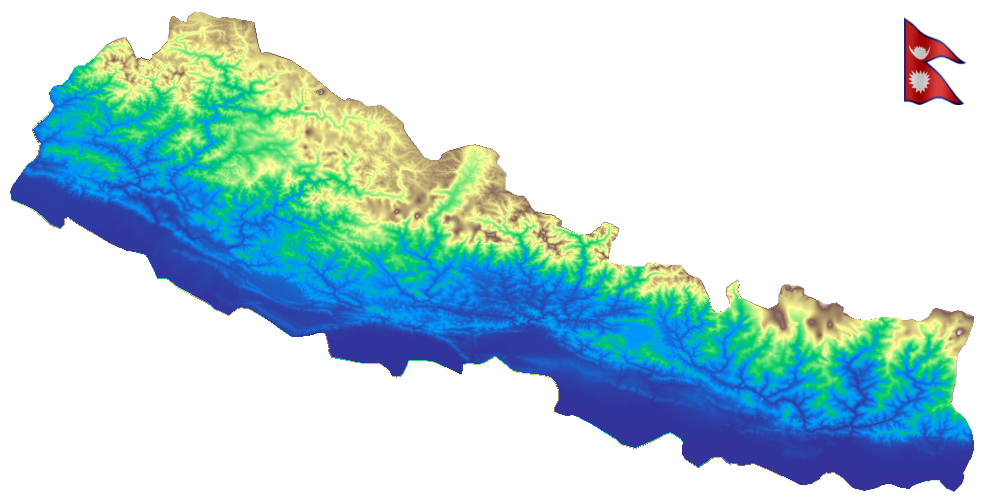

In [39]:
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

nepal_flag_path = "/kaggle/input/flag-of-nepal/nepal-nepali.gif"

# Load the animated GIF
nepal_flag = Image.open(nepal_flag_path)
nepal_flag = nepal_flag.convert("RGBA")
nepal_flag = nepal_flag.resize((90, 130))


# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the topography image
im = ax.imshow(nepal_topography[0], cmap="terrain")

# Overlay the Nepal flag
imagebox = OffsetImage(np.array(nepal_flag), zoom = 0.5, resample = True)
ab = AnnotationBbox(imagebox, 
                    (0.96,0.9), 
                    frameon = False, 
                    xycoords='axes fraction', 
                    boxcoords="axes fraction")
ax.add_artist(ab)

ax.axis("off")
plt.tight_layout()
for i in range(10):
    plt.savefig(f"./map-nepal_frame_{i}.png")
    
frames = [Image.open(f"./map-nepal_frame_{i}.png") for i in range(10)]

frames[0].save("./map-nepal.gif", 
         save_all = True, 
         append_images = frames[1:], 
         duration = 100, loop = 0)

for i in range(10):
    os.remove(f"./map-nepal_frame_{i}.png")
plt.show()

# Analysing the Data

#### Which Lat and Long Experienced the Highest Number of Earthquake??

In [40]:
place = earthquake_df_new[(earthquake_df_new["Latitute"].astype("str")+"-"+earthquake_df_new["Longitude"].astype("str"))==(earthquake_df_new["Latitute"].astype("str")+"-"+earthquake_df_new["Longitude"].astype("str")).value_counts().idxmax()]["Epicenter"].unique()[0]
times = len(earthquake_df_new[(earthquake_df_new["Latitute"].astype("str")+"-"+earthquake_df_new["Longitude"].astype("str"))==(earthquake_df_new["Latitute"].astype("str")+"-"+earthquake_df_new["Longitude"].astype("str")).value_counts().idxmax()])
latitude = earthquake_df_new[(earthquake_df_new["Latitute"].astype("str")+"-"+earthquake_df_new["Longitude"].astype("str"))==(earthquake_df_new["Latitute"].astype("str")+"-"+earthquake_df_new["Longitude"].astype("str")).value_counts().idxmax()]["Latitute"].unique()[0]
longitude = earthquake_df_new[(earthquake_df_new["Latitute"].astype("str")+"-"+earthquake_df_new["Longitude"].astype("str"))==(earthquake_df_new["Latitute"].astype("str")+"-"+earthquake_df_new["Longitude"].astype("str")).value_counts().idxmax()]["Longitude"].unique()[0]

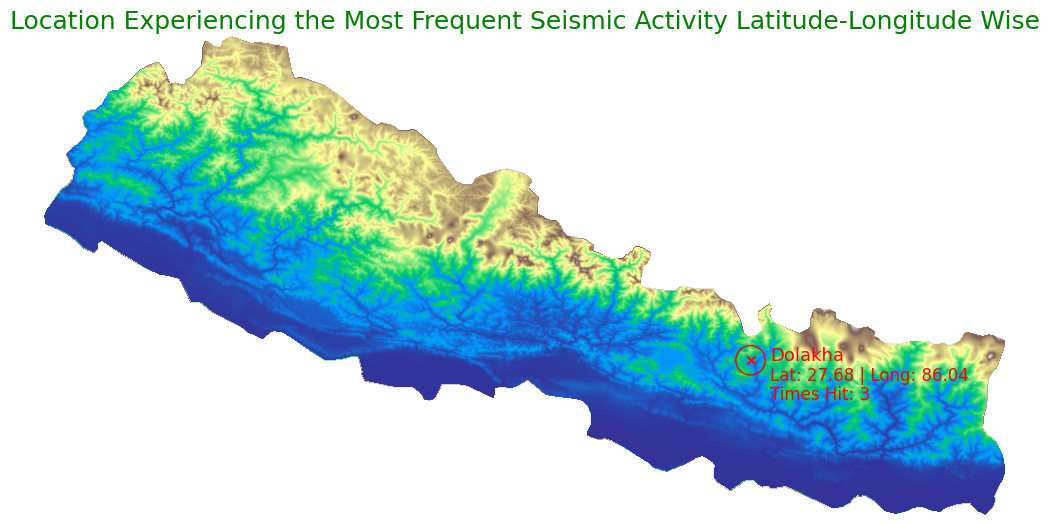

In [41]:
# Convert latitude and longitude to pixel coordinates
col, row = rasterio.transform.rowcol(clipped_transform,longitude, latitude)

# Extracting Elevation at Epicenter
elevation_epicenter = nepal_topography[0, col, row]

# Plotting the map
plt.figure(figsize = (10,10))
plt.imshow(nepal_topography[0], cmap = "terrain")
plt.scatter(row, col, color = "red", marker = "x")
circle = plt.Circle([row,col], radius = 15, fill = False, color = "red")
plt.gca().add_patch(circle)
plt.text(row+20, col, s = place, color = "red", fontsize = 13)
plt.text(row+20, col + 20, s = f"Lat: {latitude} | Long: {longitude}", color = "red", fontsize = 12)
plt.text(row+20, col+40, s = f"Times Hit: {times}", color = "red", fontsize = 12)
plt.axis("off")
plt.title("Location Experiencing the Most Frequent Seismic Activity Latitude-Longitude Wise", fontsize = 18, color = "Green")
plt.tight_layout()
plt.savefig("./most-freq-lat-longwise.jpg", bbox_inches = "tight", pad_inches = 0.1)
plt.show()

#### Extracting Elevation of all Epicenters

In [42]:
earthquake_df_new.head()

Date      Time  Latitute  Longitude  Magnitude Epicenter  Year     Month       Day                   Geometry
0 2023-11-05  08:39:00     28.91      82.20        4.1  Jajarkot  2023  November    Sunday  POINT (28.91000 82.20000)
1 2023-11-04  19:37:00     28.88      82.20        4.0  Jajarkot  2023  November  Saturday  POINT (28.88000 82.20000)
2 2023-11-04  09:55:00     28.94      82.24        4.2  Jajarkot  2023  November  Saturday  POINT (28.94000 82.24000)
3 2023-11-03  22:31:00     28.92      82.26        4.6  Jajarkot  2023  November    Friday  POINT (28.92000 82.26000)
4 2023-11-03  18:50:00     28.88      82.20        4.3  Jajarkot  2023  November    Friday  POINT (28.88000 82.20000)

In [43]:
earthquake_df_new.tail()

Date      Time  Latitute  Longitude  Magnitude       Epicenter  Year     Month       Day                   Geometry
1090 2000-03-13        NG    27.730     87.710        5.1   Sankhuwasabha  2000     March    Monday  POINT (27.73000 87.71000)
1091 2000-03-13        NG    29.770     81.410        4.2         Bajhang  2000     March    Monday  POINT (29.77000 81.41000)
1092 2000-02-26        NG    28.617     82.314        5.1        Jajarkot  2000  February  Saturday  POINT (28.61700 82.31400)
1093 2000-01-25  12:07:00    27.378     88.059        4.6       Taplejung  2000   January   Tuesday  POINT (27.37800 88.05900)
1094 2000-01-20        NG    27.928     86.060        4.8  Sindhupalchowk  2000   January  Thursday  POINT (27.92800 86.06000)

In [44]:
elevations = []

for lat, long in zip(earthquake_df_new["Latitute"], earthquake_df_new["Longitude"]):
    col, row = rasterio.transform.rowcol(clipped_transform, long, lat)
    if ((col<=nepal_topography[0].shape[0]) & (row<=nepal_topography[0].shape[1])):
        elevations.append(nepal_topography[0, col, row])
    else:
        elevations.append("Abroad")
    

In [45]:
earthquake_df_new["Elevation"] = elevations

**Magnitude of Seismic Activity at Region Where the Earthquake Hit the Most**

In [46]:
filtered_place = earthquake_df_new[earthquake_df_new["Epicenter"]==place]
unique_years = sorted(filtered_place["Year"].unique())
grouped_unique_years = [unique_years[i:i+4] for i in range(0,len(unique_years),4)]


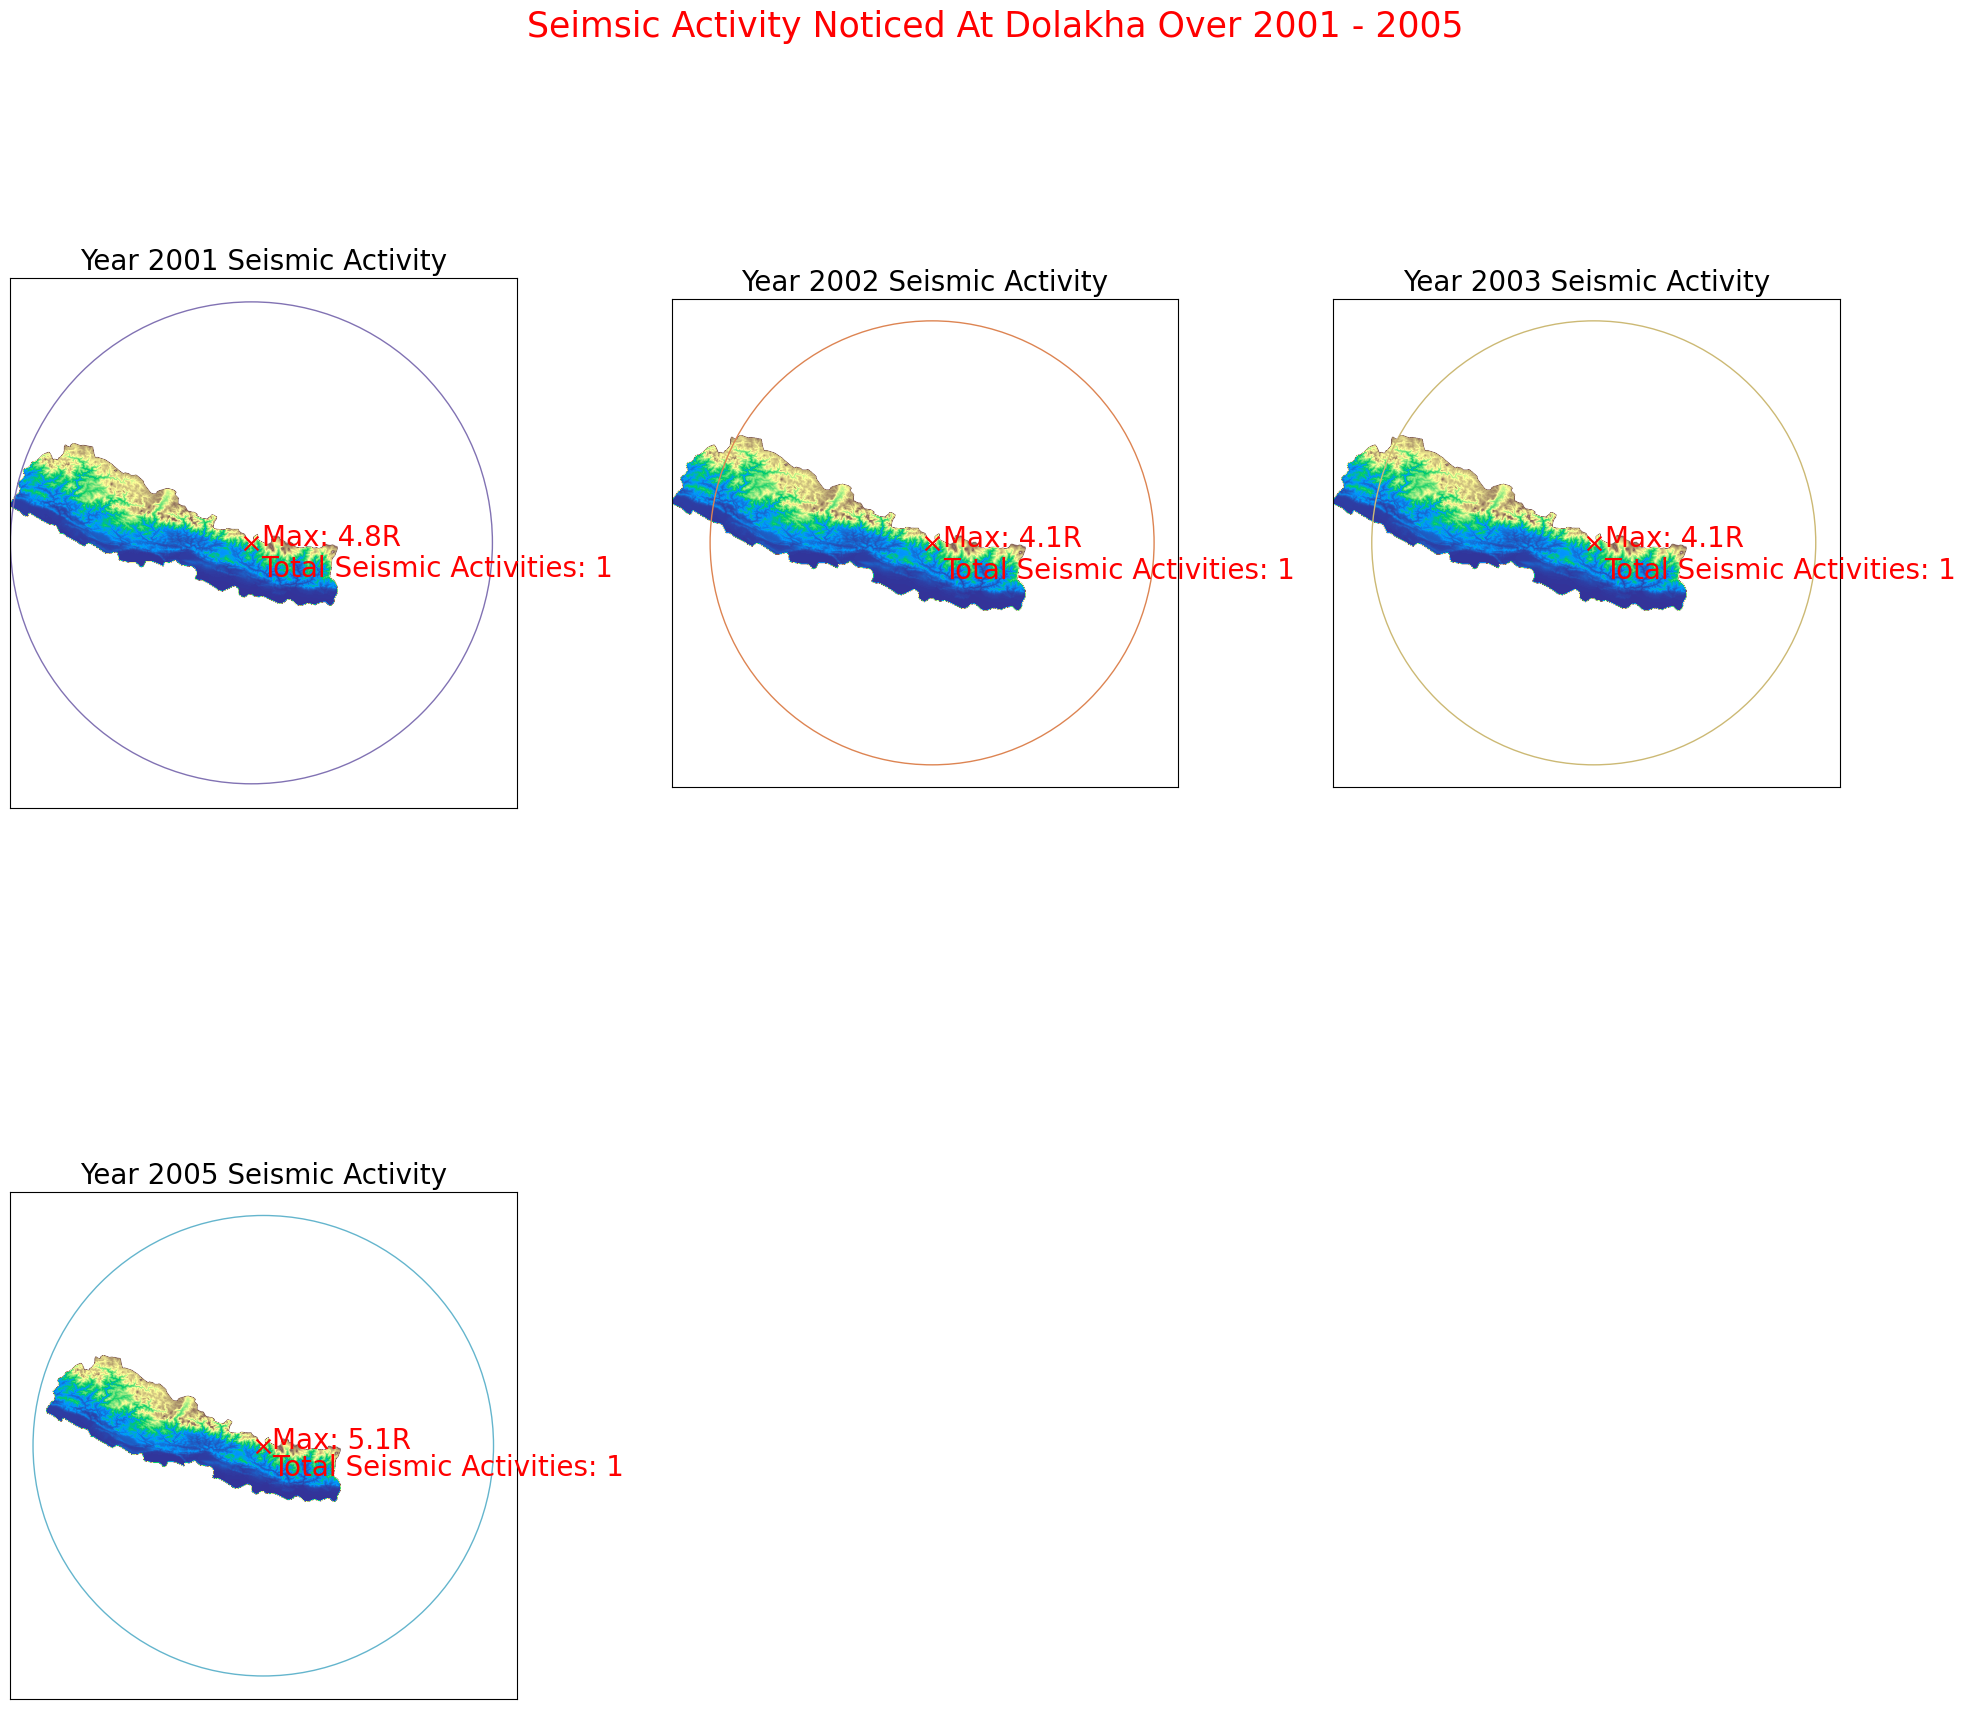

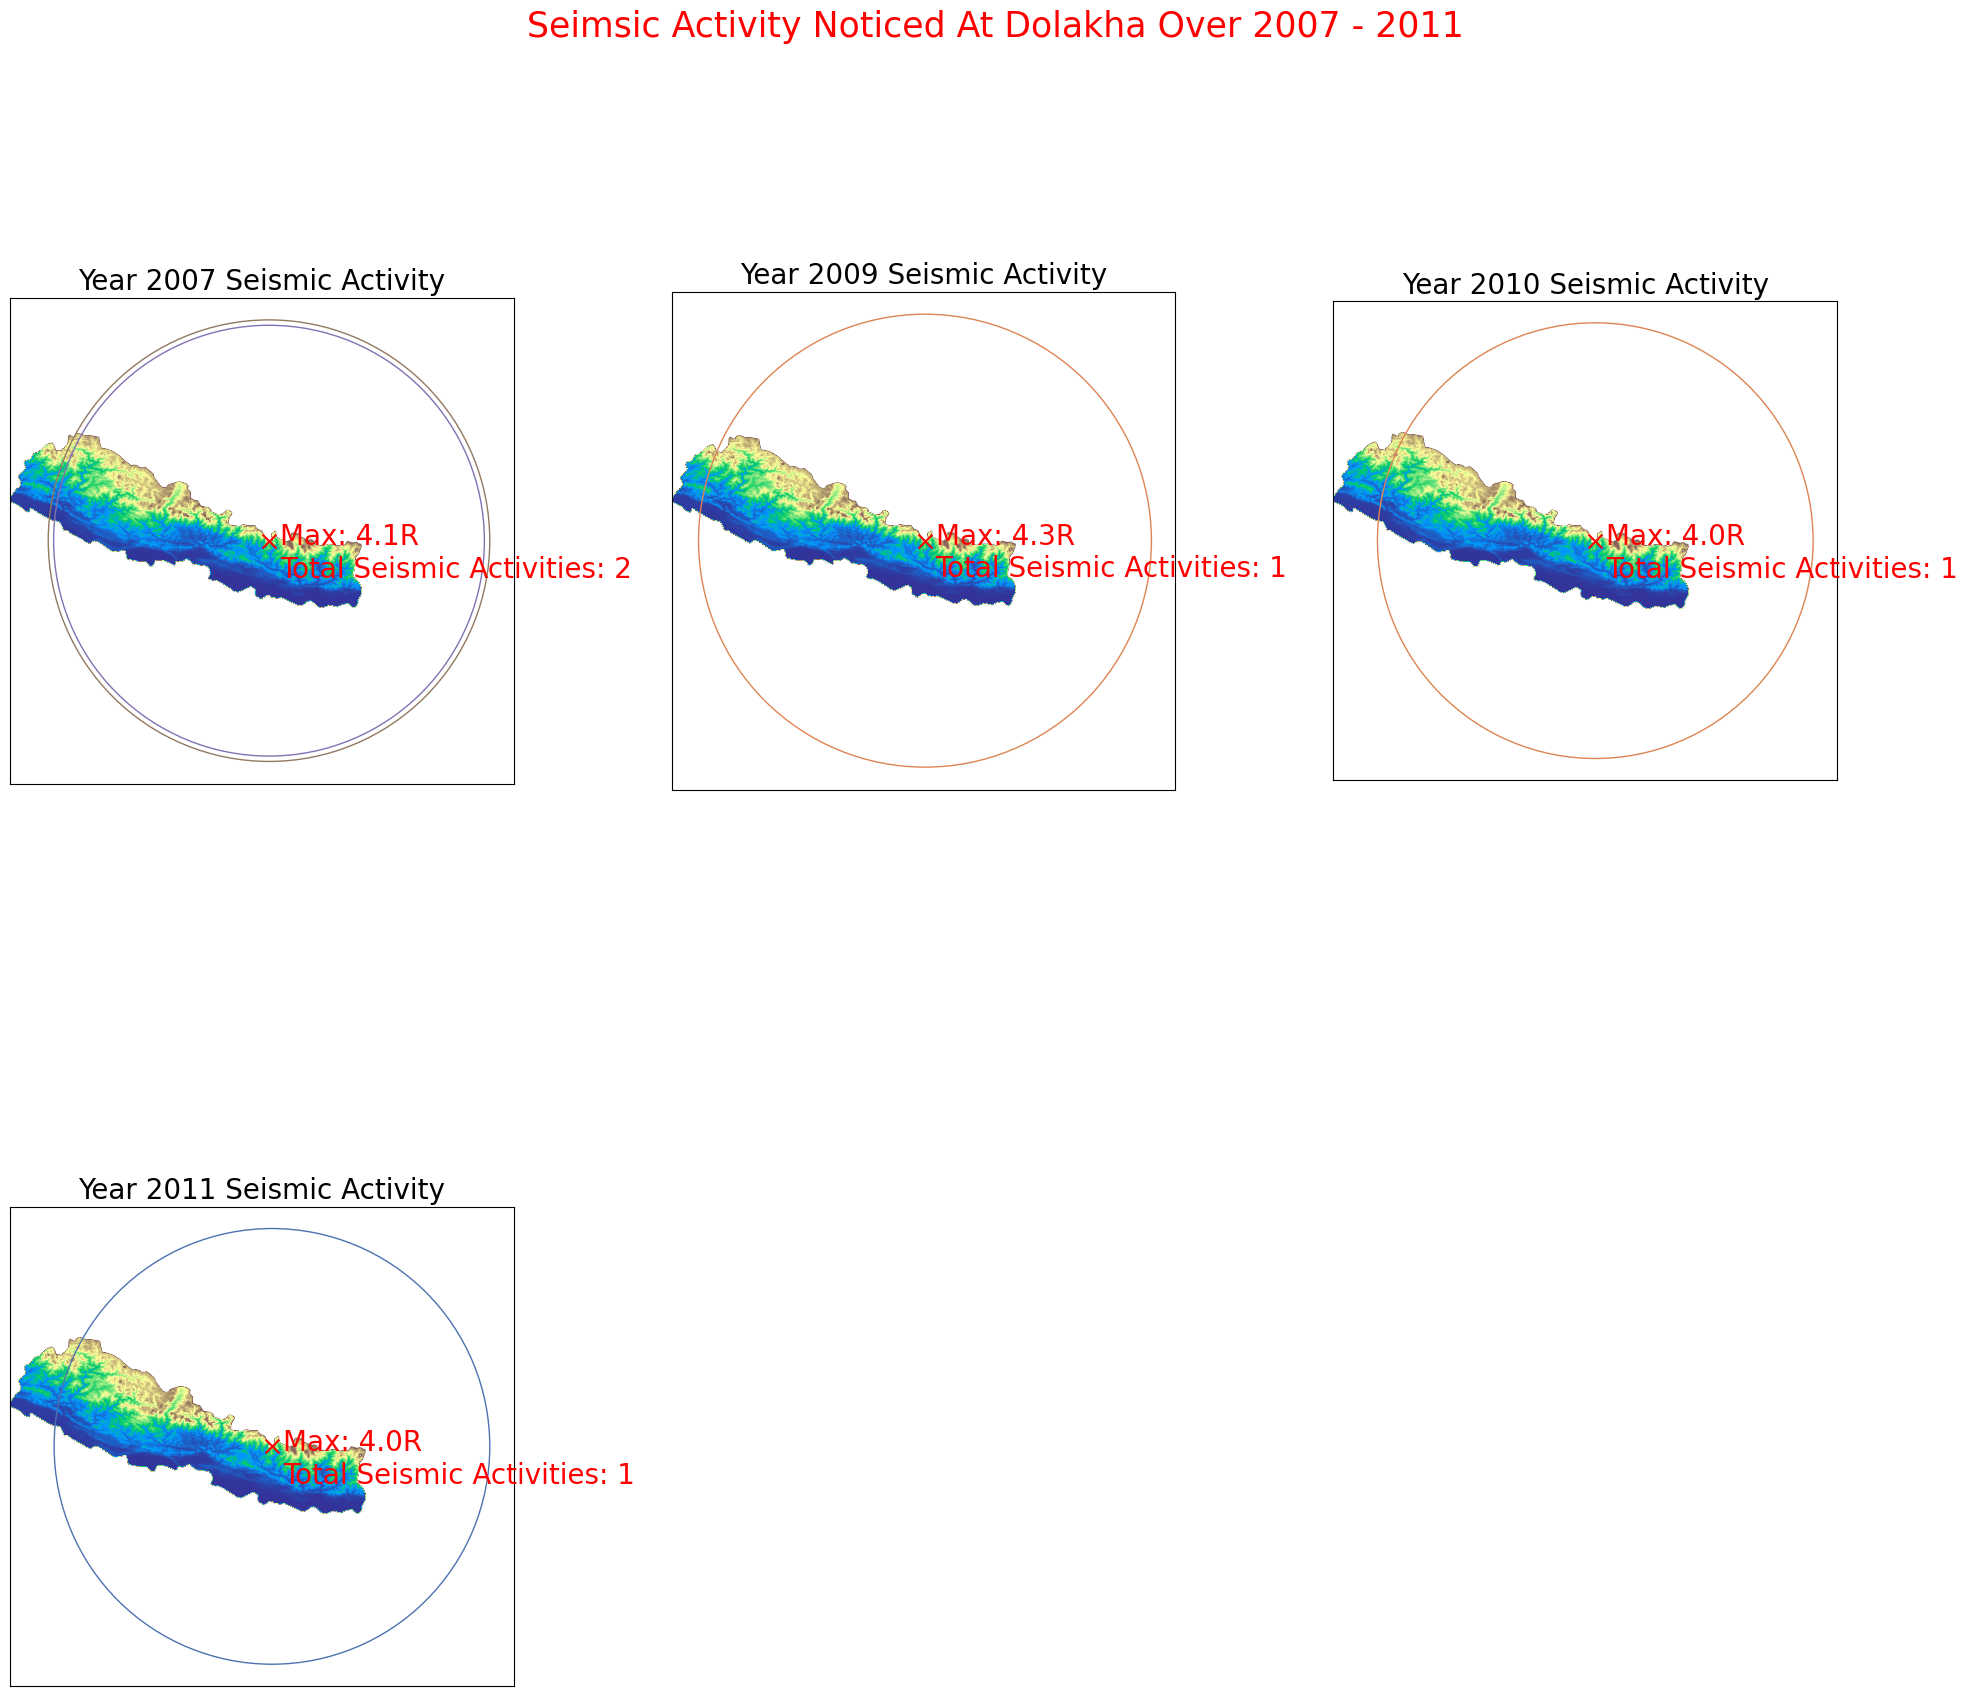

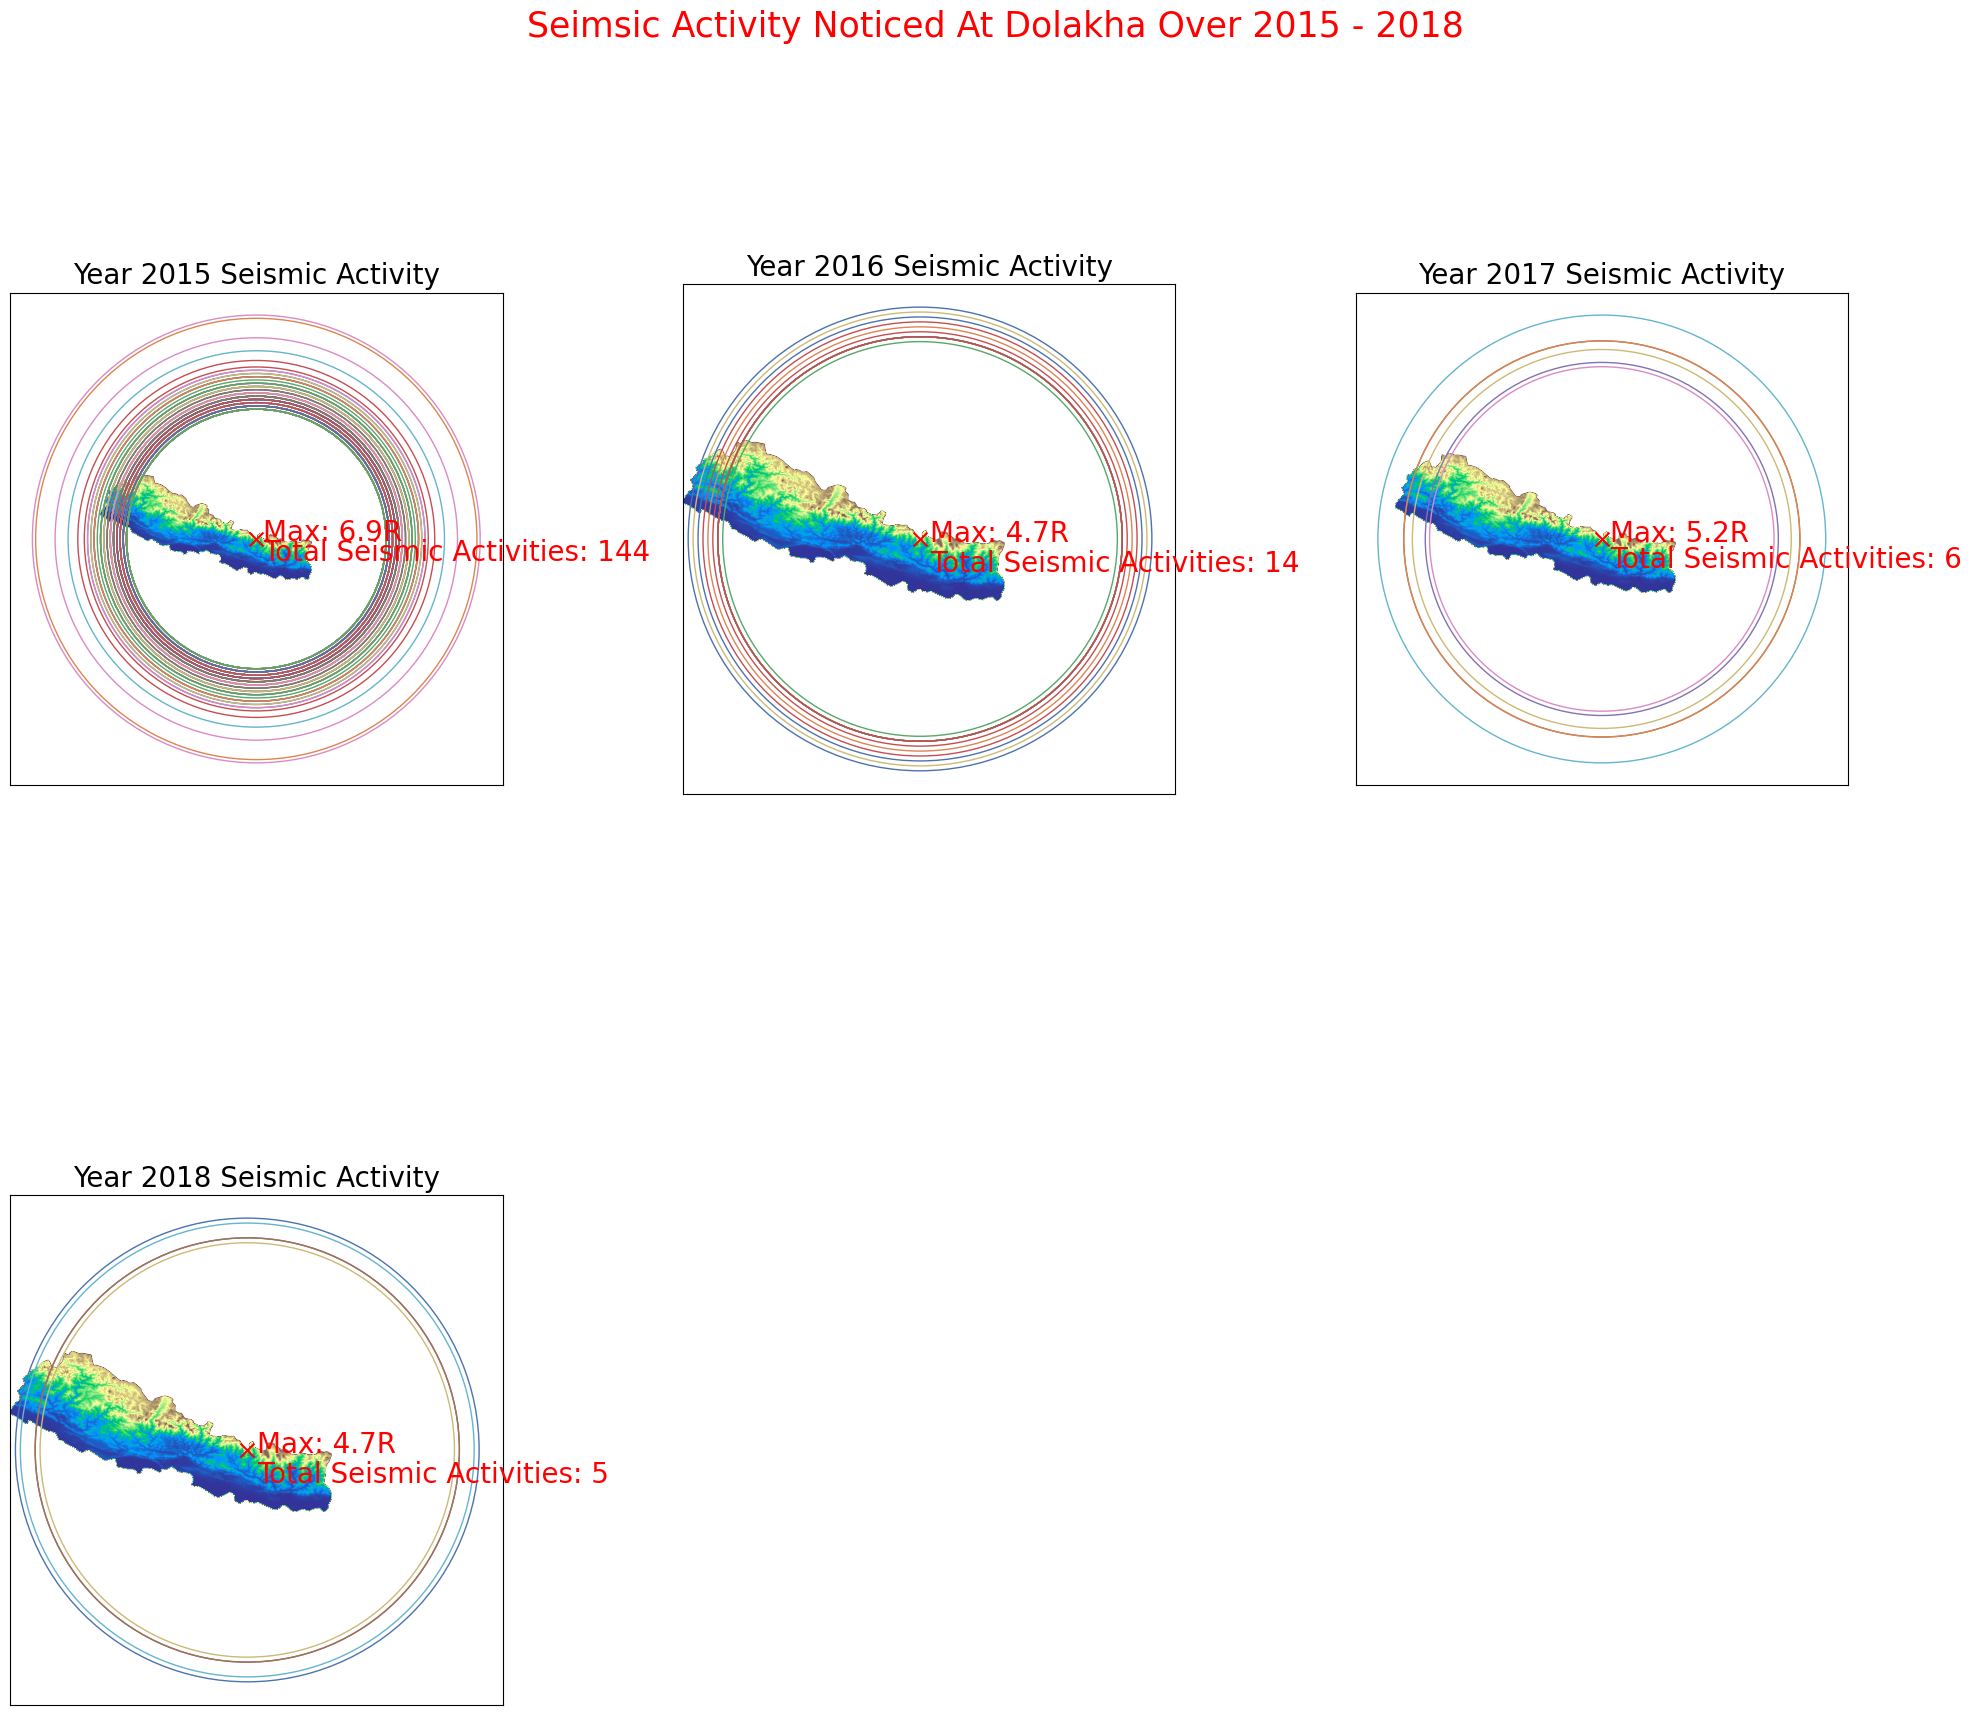

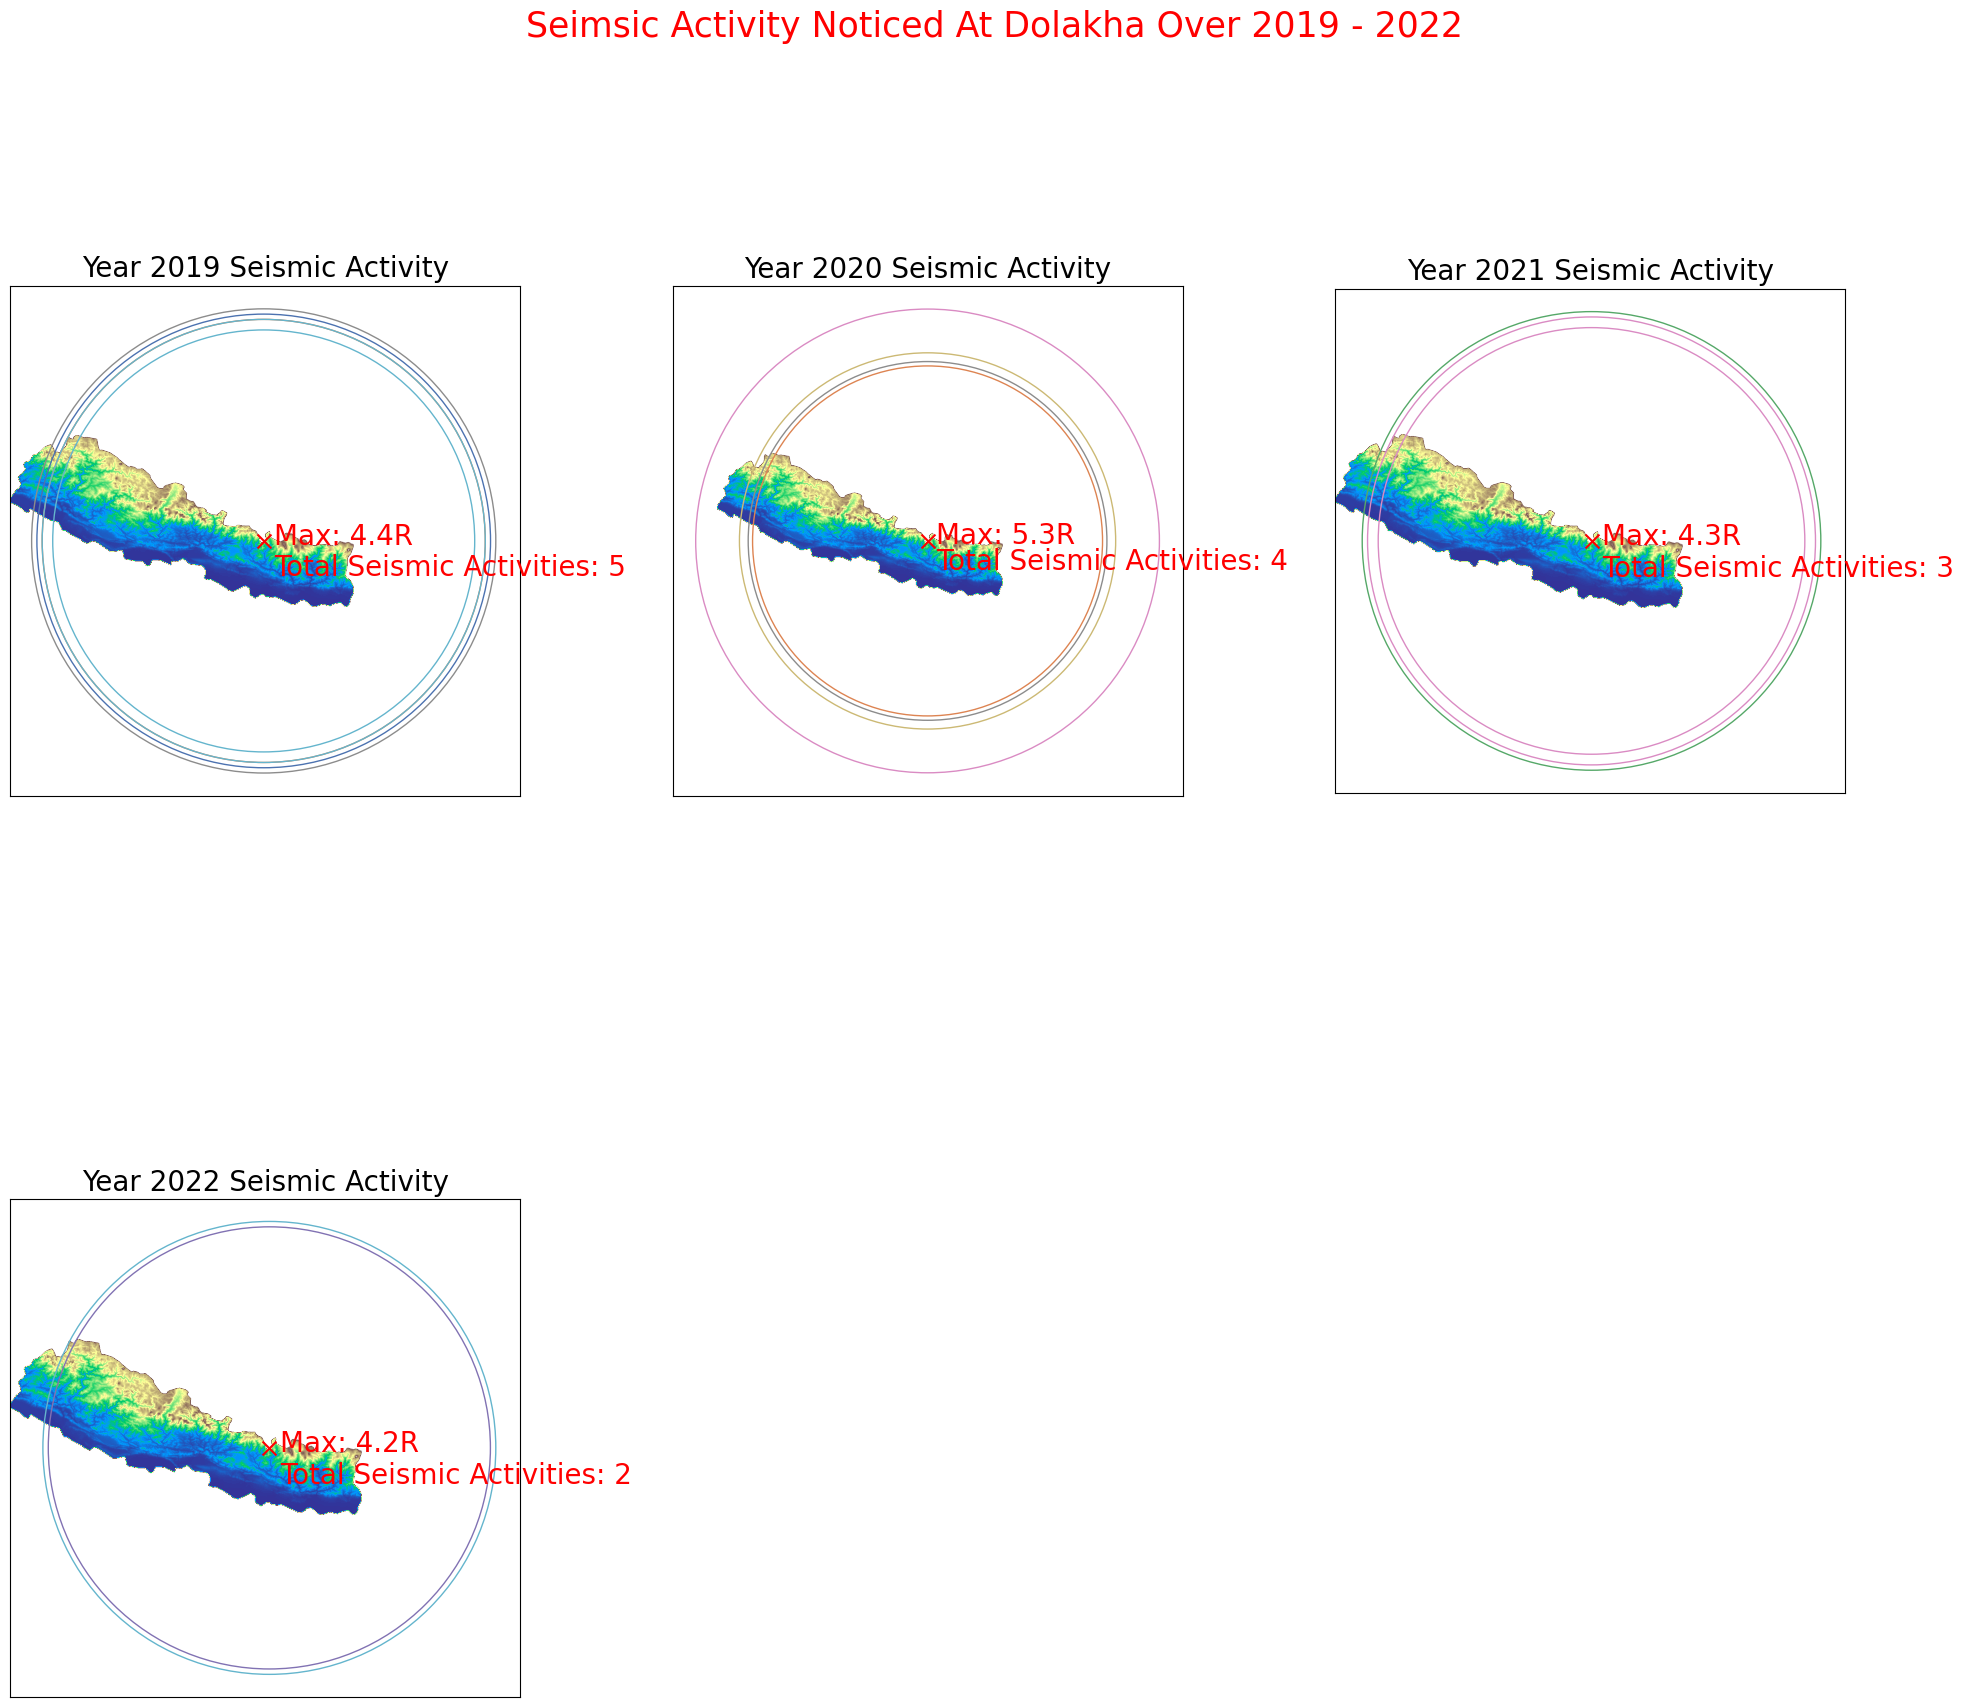

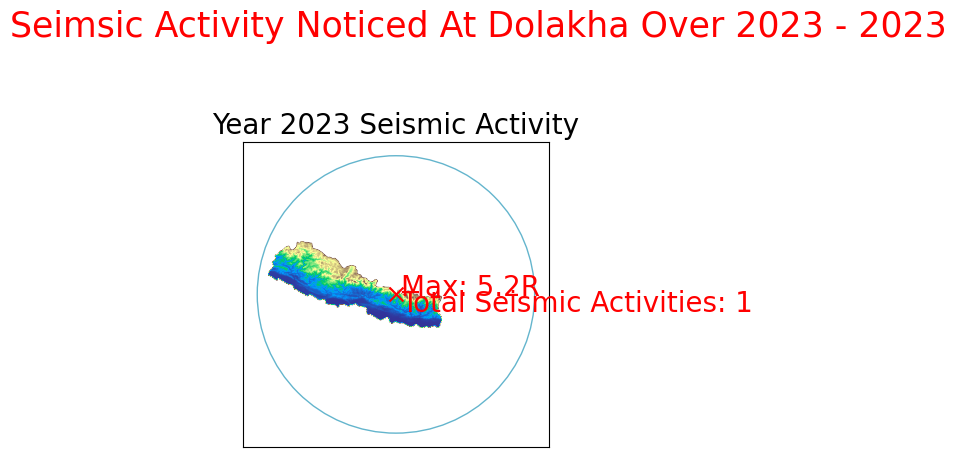

In [47]:
for split_years in grouped_unique_years:
    
    if len(split_years)>1:
        fig, axes = plt.subplots(nrows = len(split_years)//2,
                                ncols = len(split_years)//2 + 1,
                                figsize = (20,20))
    else:
        
        fig, axes = plt.subplots(nrows = len(split_years),
                                ncols = len(split_years),
                                figsize = (5,5))


    for i, year in enumerate(split_years):
        if len(split_years)>1:
            ax = axes.flatten()[i]
        else:
            ax = axes
        data_year = filtered_place[filtered_place["Year"]== year]
        total_recorded = len(data_year)
        ax.imshow(nepal_topography[0], cmap = "terrain")
        ax.scatter(row, col, color = "red", marker = "x", s = 100)
        temp = 0
        for val in data_year["Magnitude"].values:
            if val>temp:
                temp = val
            circle = plt.Circle([row, col], 
                                radius = val*150, 
                                fill = False, 
                                color = random.choice(sns.color_palette(palette="deep")))
            ax.add_patch(circle)
        ax.text(row + 30, col + 10, f"Max: {temp}R", fontsize = 20, color = "red")
        ax.text(row+30, col+100, f"Total Seismic Activities: {total_recorded}", fontsize = 20, color = "red")        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Year {year} Seismic Activity", fontsize = 20)
    if len(split_years)>1:
        for i in range(len(split_years), len(axes.flatten())):
            fig.delaxes(axes.flatten()[i])

    fig.suptitle(f"Seimsic Activity Noticed At {place} Over {split_years[0]} - {split_years[-1]}",
             color = "red", fontsize = 25)
    if len(split_years)>1:
        plt.tight_layout()
    else:
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"./seismic_activity_{place}_over_{split_years[0]} - {split_years[-1]}.jpg")
    plt.show()

**Is there a trend in Seismic Activity Magnitude at Dolakha Over the Years?**

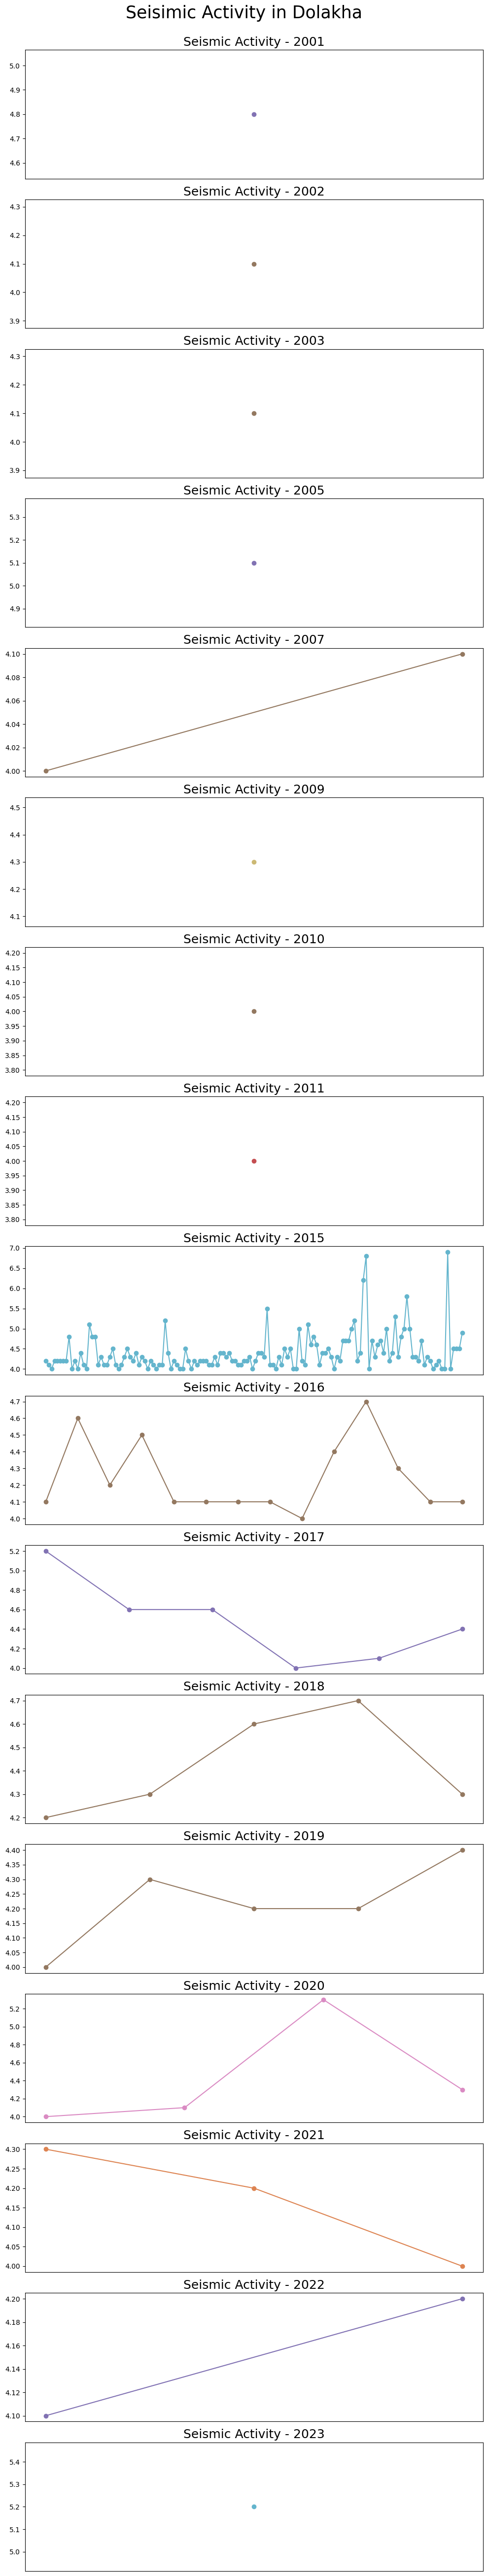

In [48]:
data_plot = filtered_place.groupby(["Year"])["Magnitude"]
to_plot = data_plot.count().max()
fig, ax = plt.subplots(nrows = len(data_plot), ncols = 1, figsize = (10,55))
ax.ravel()
pos = 0
for yr, mag in data_plot:
    
    ax[pos].plot([i for i in range(to_plot)],
                  list(mag.values) + [None] * abs(to_plot - len(mag)) if len(mag)<to_plot else mag.values,
                 marker = "o", linestyle = "-", color = random.choice(sns.color_palette("deep"))
                )
    ax[pos].set_title(f"Seismic Activity - {str(yr)}", fontsize = 18)
    ax[pos].set_xticks([])
    
    pos+=1
        
plt.suptitle(f"Seisimic Activity in {place}", fontsize = 25)
plt.xticks([])
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig("./seismic-activity-lineplot-dolakha.jpg")


**Prior to 2015, seismic activity in Dolakha was virtually non-existent between 2001 and 2011. Unfortunately, there is no available data for the year 2014, which precedes the significant surge in earthquake occurrences, totaling 144 times.**

**Subsequent to 2015, there have been numerous reports of earthquakes, but the frequency appears to be decreasing.**







## Which Place is Having the Highest Fluctuation in the Seismic Magnitude? (TimeFrame: Within the Last 5 years)

/tmp/ipykernel_20/3551006442.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_consider.dropna(inplace = True)


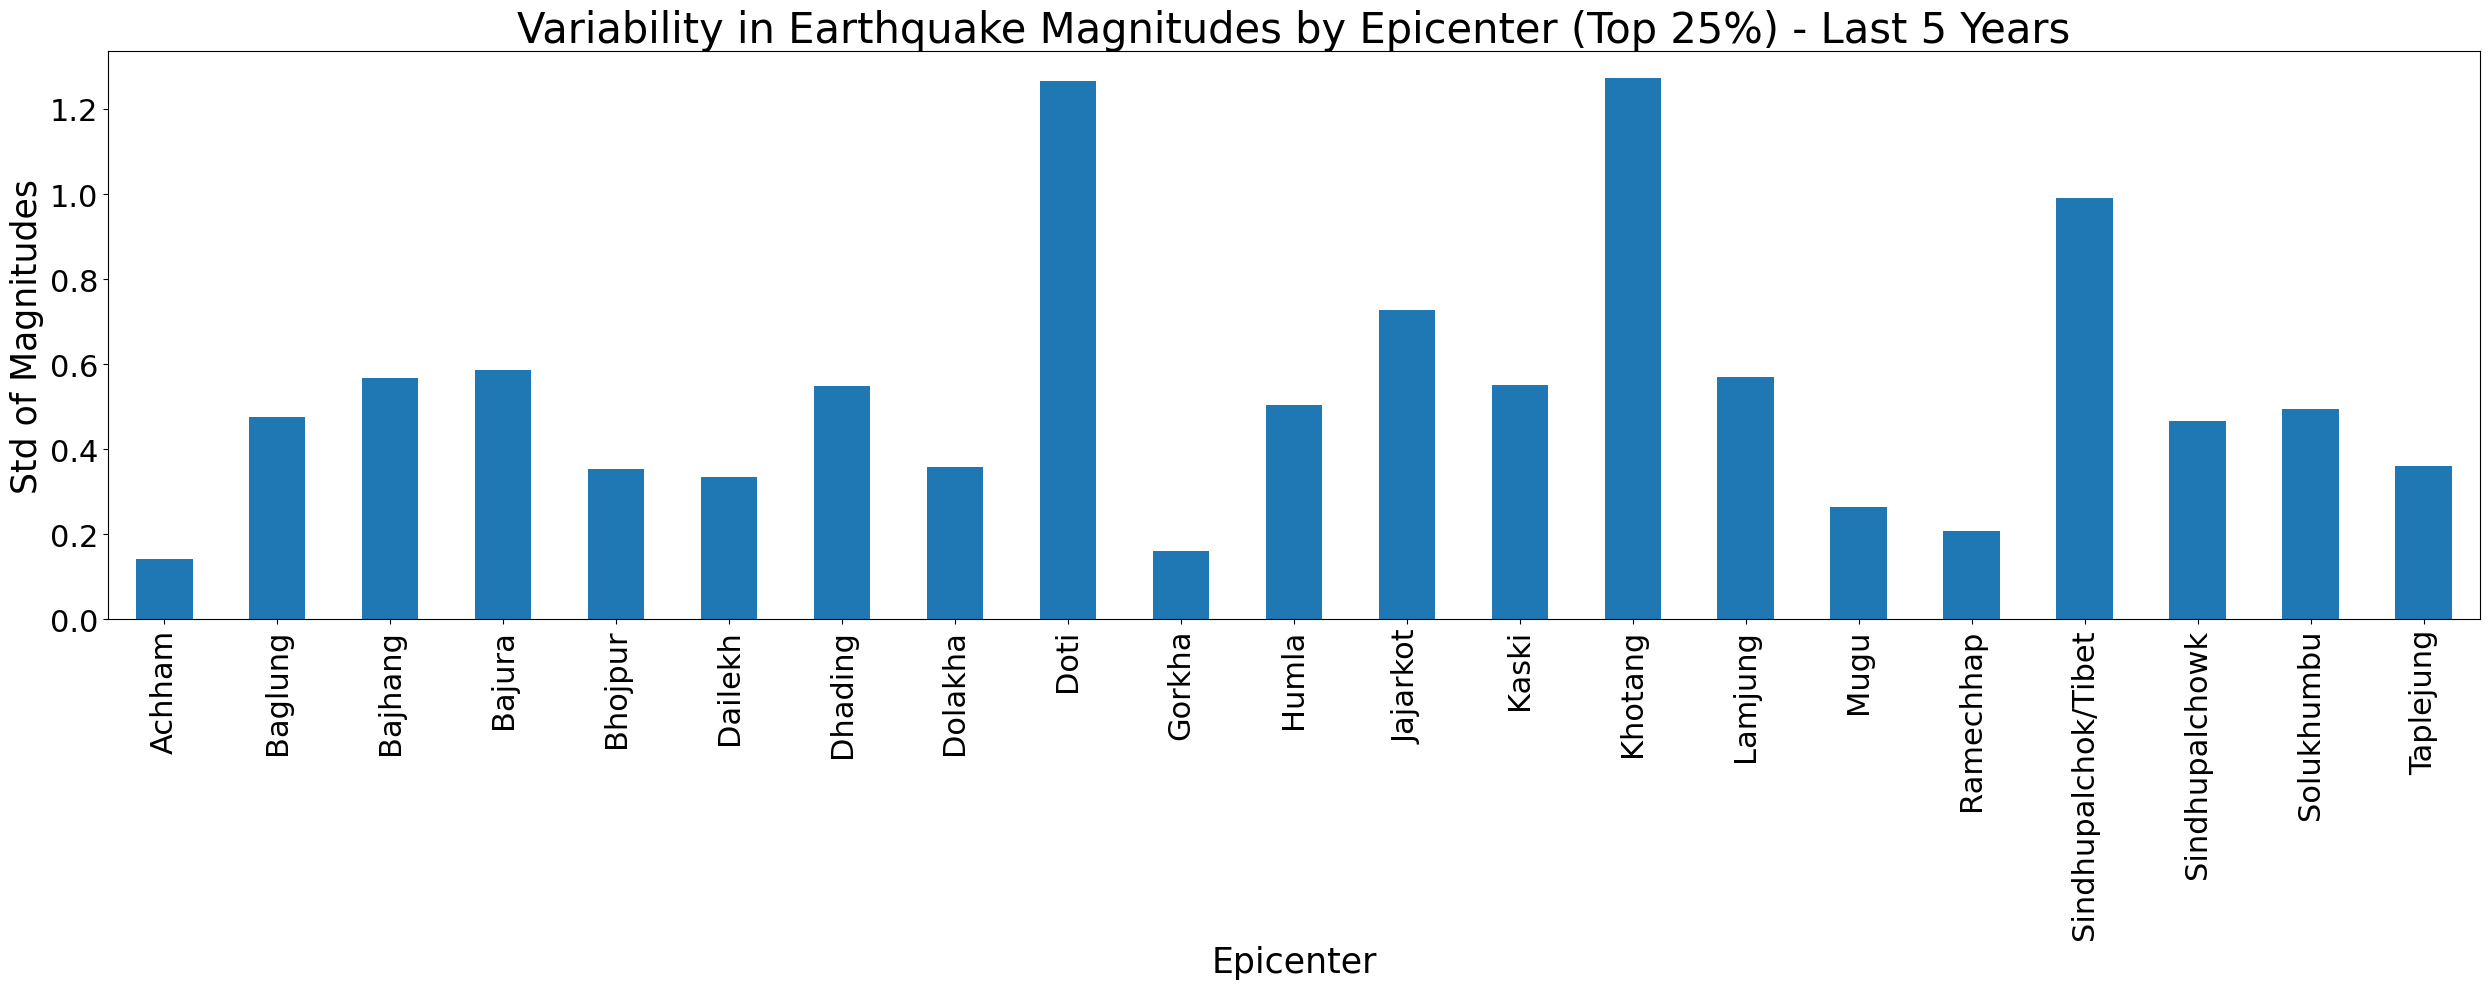

In [49]:
to_consider = earthquake_df_new[earthquake_df_new["Year"]>=earthquake_df_new["Year"].max()-5]
to_consider.dropna(inplace = True)


plt.figure(figsize = (25,10))

data = to_consider.groupby(["Epicenter"])["Magnitude"].std()
data= data[data>data.quantile(0.25)]
data.plot(kind = "bar")
plt.xticks(rotation = 90, fontsize = 22)
plt.yticks(fontsize = 22)
plt.xlabel("Epicenter", fontsize = 25)
plt.ylabel("Std of Magnitudes", fontsize = 25)
plt.title("Variability in Earthquake Magnitudes by Epicenter (Top 25%) - Last 5 Years", fontsize = 30)
plt.savefig("./variation-mag-last-5yrs.jpg", bbox_inches = "tight", pad_inches = 0.1)
plt.tight_layout()

In [50]:
largest = data.nlargest(3)

**Plotting these regions in map of Nepal**

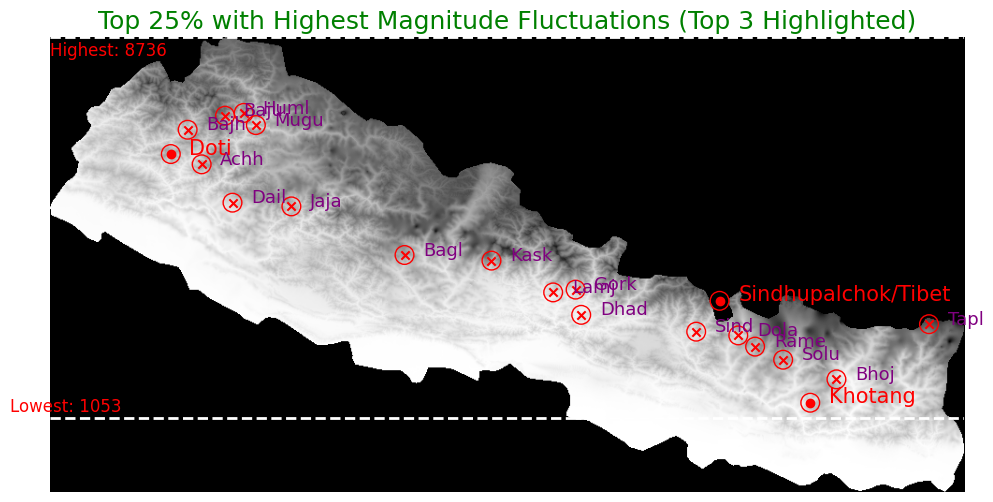

In [51]:
# %matplotlib widget

fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(nepal_topography[0], cmap = "binary")

highest_elevation_point = 0
lowest_elevation_point = 0
for idx in data.index:
    lat, long = earthquake_df_new[earthquake_df_new["Epicenter"]==idx]["Latitute"].values[0], earthquake_df_new[earthquake_df_new["Epicenter"]==idx]["Longitude"].values[0]
   
    col, row = rasterio.transform.rowcol(clipped_transform,long, lat)
    elevation_epicenter = nepal_topography[0, col, row]
    
    if elevation_epicenter>highest_elevation_point:
        highest_elevation_point = elevation_epicenter
    
    if lowest_elevation_point == 0:
        lowest_elevation_point = elevation_epicenter
    elif elevation_epicenter < lowest_elevation_point:
        lowest_elevation_point = elevation_epicenter
    
    # Plotting the map
    
    if idx not in largest.index:
        ax.scatter(row, col, color = "red", marker = "x")
        circle = plt.Circle([row,col], radius = 10, fill = False, color = "red")
        ax.add_patch(circle)
        plt.text(row+20, col, s = idx[:4], color = "purple", fontsize = 13)
    else:
        ax.scatter(row, col, color = "red", marker = "o")
        circle = plt.Circle([row,col], radius = 10, fill = False, color = "red")
        ax.add_patch(circle)
        plt.text(row+20, col, s = idx, color = "red", fontsize = 15)
    
pos_high = np.where(nepal_topography[0]==highest_elevation_point)
row_high, col_high = np.min(pos_high[0]), np.min(pos_high[1])

pos_low = np.where(nepal_topography[0]==lowest_elevation_point)
row_low, col_low = np.max(pos_low[0]), np.max(pos_low[1])

ax.axhline(row_high, color = "white", linestyle = "--", linewidth = 2)
plt.text(row_high, col_high + 20, s = "Highest: "+str(highest_elevation_point), fontsize = 12, color = "red")

ax.axhline(row_low, color = "white", linestyle = "--", linewidth = 2)
plt.text(row_low-450, col_high+400, s = "Lowest: "+str(lowest_elevation_point), fontsize = 12, color = "red")
ax.axis("off")
plt.title("Top 25% with Highest Magnitude Fluctuations (Top 3 Highlighted)", fontsize = 18, color = "Green")
plt.tight_layout()
plt.savefig("./top-25%-high-fluc.jpg")
plt.show()

    
        

* The most significant variations in seismic magnitude are observed within the altitude range of 1053 m to 8736 m.

* Based on data from the last 5 years (as of 2023), regions with the highest variations include Khotang, Sindhupalchok/Tibet Border, and Doti.

* Notably, Khotang and Sindhupalchok/Tibet Border, both located in the eastern part of the country, along with Doti in the western part, exhibit substantial seismic fluctuations.

* This observation underscores a concentration of seismic centers with the highest magnitude variations in both the Eastern and Western parts of the country.

### Is there a relationship between Earthquake Magnitude and Elevation

In [52]:
places_in_nepal = earthquake_df_new[earthquake_df_new["Elevation"]!="Abroad"]
places_in_nepal["Elevation"] = pd.to_numeric(places_in_nepal["Elevation"])

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [53]:
places_in_nepal.head()

Date      Time  Latitute  Longitude  Magnitude Epicenter  Year     Month       Day                   Geometry  Elevation
0 2023-11-05  08:39:00     28.91      82.20        4.1  Jajarkot  2023  November    Sunday  POINT (28.91000 82.20000)       2662
1 2023-11-04  19:37:00     28.88      82.20        4.0  Jajarkot  2023  November  Saturday  POINT (28.88000 82.20000)       2439
2 2023-11-04  09:55:00     28.94      82.24        4.2  Jajarkot  2023  November  Saturday  POINT (28.94000 82.24000)       1854
3 2023-11-03  22:31:00     28.92      82.26        4.6  Jajarkot  2023  November    Friday  POINT (28.92000 82.26000)       2277
4 2023-11-03  18:50:00     28.88      82.20        4.3  Jajarkot  2023  November    Friday  POINT (28.88000 82.20000)       2439

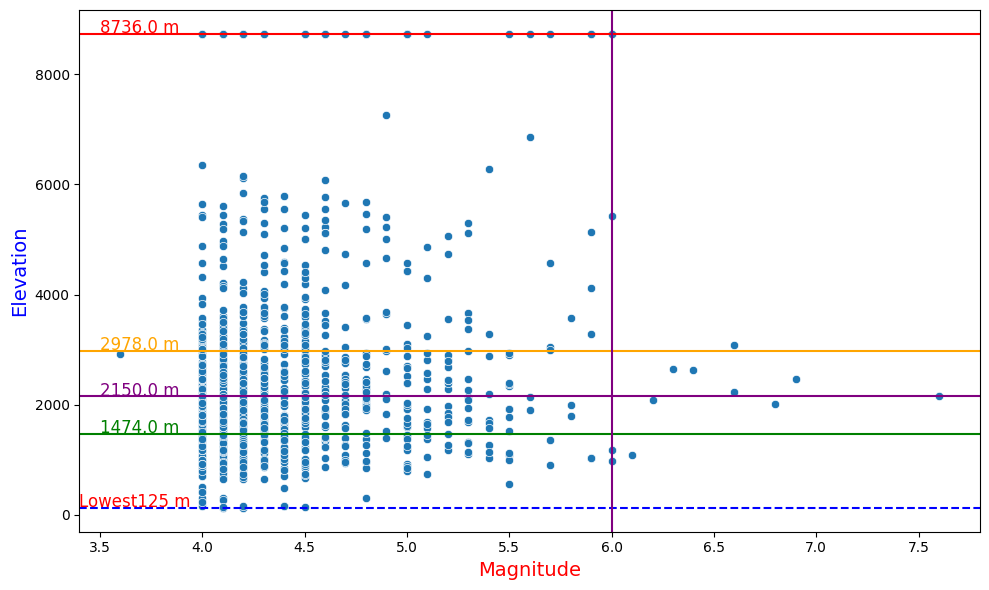

In [54]:
fig, ax = plt.subplots(figsize = (10,6))
sns.scatterplot(data = places_in_nepal, x = "Magnitude", y = "Elevation", ax =ax)
ax.axhline(places_in_nepal["Elevation"].min(), color = "blue", linestyle = "--")
plt.text(x = 3.4, 
         y = places_in_nepal["Elevation"].min()+15, 
         s= "Lowest" + str(places_in_nepal["Elevation"].min())+" m", 
         color = "red",
         fontsize = 12)

ax.axhline(places_in_nepal["Elevation"].quantile(0.25), color = "green")
plt.text(x = 3.5, 
         y = places_in_nepal["Elevation"].quantile(0.25)+15, 
         s= str(places_in_nepal["Elevation"].quantile(0.25))+" m", 
         color = "green",
         fontsize = 12)


ax.axhline(places_in_nepal["Elevation"].quantile(0.50), color = "purple")
plt.text(x = 3.5, 
         y = places_in_nepal["Elevation"].quantile(0.50)+15, 
         s= str(np.round(places_in_nepal["Elevation"].quantile(0.50),1))+" m", 
         color = "purple",
         fontsize = 12)


ax.axhline(places_in_nepal["Elevation"].quantile(0.75), color = "orange")
plt.text(x = 3.5, 
         y = places_in_nepal["Elevation"].quantile(0.75)+15, 
         s= str(np.round(places_in_nepal["Elevation"].quantile(0.75),1))+" m", 
         color = "orange",
         fontsize = 12)


ax.axhline(places_in_nepal["Elevation"].quantile(1), color = "red")
plt.text(x = 3.5, 
         y = places_in_nepal["Elevation"].quantile(1)+15, 
         s= str(np.round(places_in_nepal["Elevation"].quantile(1),1))+" m", 
         color = "red",
         fontsize = 12)

ax.axvline(x = 6, color = "purple")
plt.xlabel(xlabel = "Magnitude", fontsize = 14, color = "red")
plt.ylabel(ylabel = "Elevation", fontsize = 14, color = "blue")
plt.tight_layout()
plt.savefig("./alt-mag-relation.jpg")
plt.show()

* Seismic activity with a magnitude exceeding 6 is concentrated within the elevation range of 2150 to 2978 meters.

* This specific region, characterized by elevations between 2150 to 2978 meters, is notably susceptible to significant earthquakes.

* In the elevation bands of 125 to 1474 meters and 2978 to 8736 meters, the magnitudes of most seismic activities tend to be either below 6 or hover around the borderline magnitude.

* The observed pattern suggests varying susceptibility to seismic events across different elevation ranges.

#### Plotting the Regions Between 2140 m to 2980 m

In [55]:
risky_places = places_in_nepal[(places_in_nepal["Elevation"]>=2140) & (places_in_nepal["Elevation"]<=2980)]
risky_places["Mag_Class"] = pd.cut(risky_places["Magnitude"], bins = [0,5,6.5,8,10], labels = ["0-5", "5-6.5", "6.5-8", "8-10"])

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [56]:
risky_places["Mag_Class"] = risky_places["Mag_Class"].astype("category")

In [57]:
risky_row, risky_col = [], []
for i in range(len(risky_places)):
    lat, long, mag = risky_places.iloc[i]["Latitute"], risky_places.iloc[i]["Longitude"], risky_places.iloc[i]["Magnitude"]
    col, row = rasterio.transform.rowcol(clipped_transform,long, lat)
    risky_row.append(row)
    risky_col.append(col)
risky_places["Col"] = risky_col
risky_places["Row"] = risky_row

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


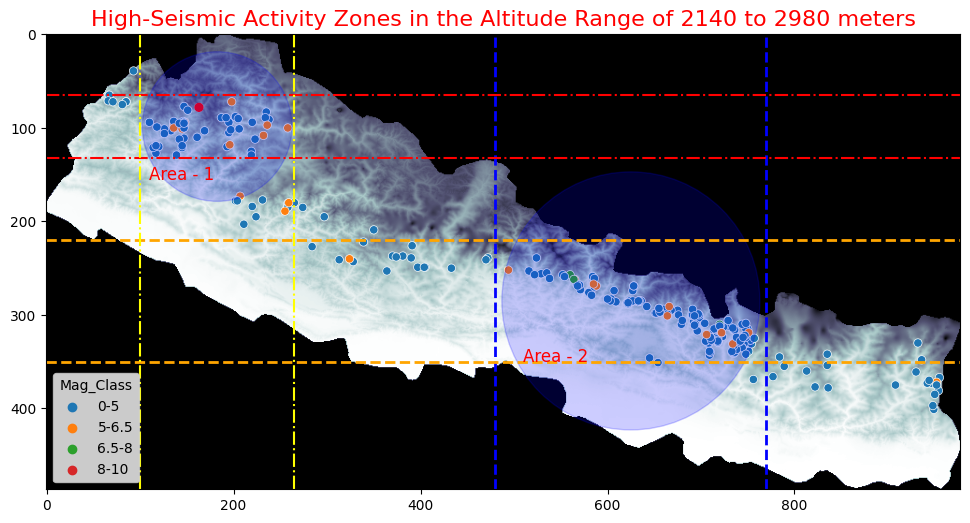

In [58]:
fig, ax = plt.subplots(figsize = (10,6))
ax.imshow(nepal_topography[0], cmap = "bone_r")

sns.scatterplot(data = risky_places, x = "Row", y = "Col", markers = "x", color = "red", hue = "Mag_Class", ax = ax, sizes = 50)
circle = plt.Circle((row, col),radius = mag, fill = True, color = "red")
ax.add_patch(circle)

ax.axvline(x = 480, color = "blue", linewidth = 2, linestyle = "--")
ax.axvline(x = 770, color = "blue", linewidth = 2, linestyle = "--")

ax.axhline(y = 220, color = "orange", linewidth = 2, linestyle = "--")
ax.axhline(y = 350, color = "orange", linewidth = 2, linestyle = "--")

circle = plt.Circle((625, 285), radius = 138, fill = True, alpha = 0.2, color = "blue")
ax.add_patch(circle)


ax.axhline(y = 65, linestyle = "-.", color = "red")
ax.axhline(y = 132, linestyle = "-.", color = "red")

ax.axvline(x = 100, linestyle = "-.", color = "yellow")
ax.axvline(x = 265, linestyle = "-.", color = "yellow")

circle = plt.Circle((182.5, 98.5),radius = 80, fill = True, alpha = 0.2, color = "blue")
ax.add_patch(circle)

plt.title("High-Seismic Activity Zones in the Altitude Range of 2140 to 2980 meters", fontsize = 16, color = "red")

plt.text(x = 110, y = 155, s = "Area - 1", color = "red",fontsize = 12)
plt.text(x = 510, y = 350, s = "Area - 2", color = "red", fontsize = 12)

plt.tight_layout()
plt.xlabel(None)
plt.ylabel(None)
plt.savefig("./seismic-activity-2140-2980m.jpg")
plt.show()


**Analyzing the High Seismic Activity Zones**

In [59]:
far_zone = risky_places[(risky_places["Row"]>=100) & 
                        (risky_places["Row"]<=265) & 
                        (risky_places["Col"]>=65) & 
                        (risky_places["Col"]<=132)]
central_zone = risky_places[(risky_places["Row"]>=480) & 
                            (risky_places["Row"]<=770) & 
                            (risky_places["Col"]>=220) & 
                            (risky_places["Col"]<=350)]

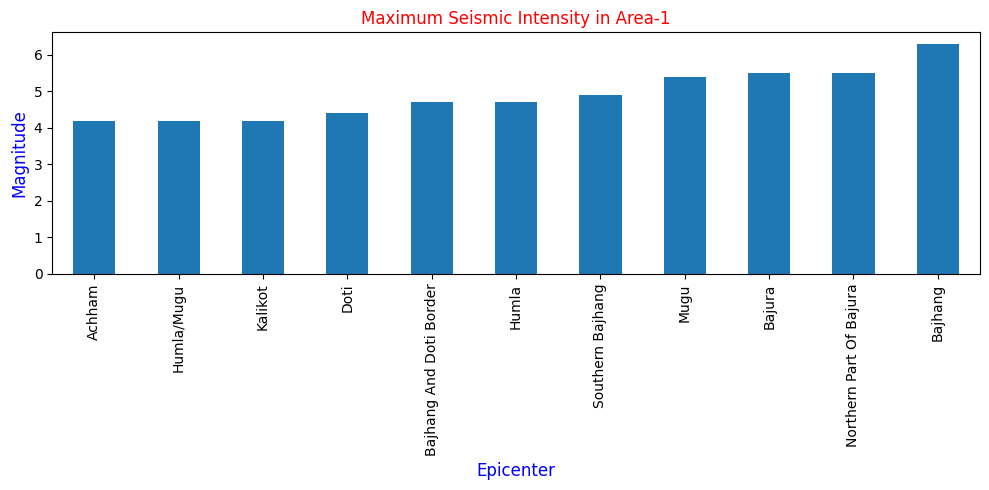

In [60]:
plt.figure(figsize = (10, 5))
far_zone.groupby(["Epicenter"])["Magnitude"].max().sort_values().plot(kind = "bar")
plt.title("Maximum Seismic Intensity in Area-1", fontsize = 12, color = "red")
plt.xlabel("Epicenter", color = "blue", fontsize = 12)
plt.ylabel("Magnitude", color = "blue", fontsize = 12)
plt.tight_layout()
plt.savefig("./max-intensity-area1.jpg", bbox_inches = "tight", pad_inches = 0.1)
plt.show()

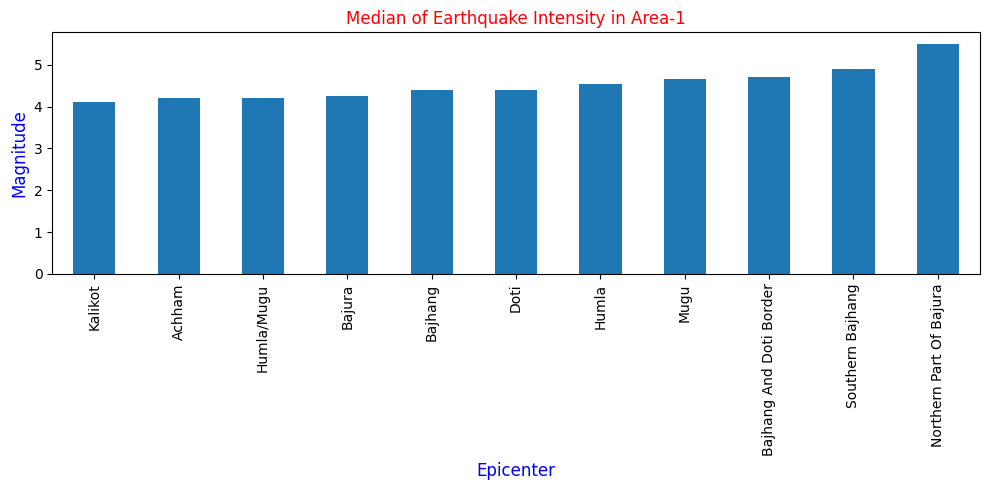

In [61]:
plt.figure(figsize = (10, 5))
far_zone.groupby(["Epicenter"])["Magnitude"].median().sort_values().plot(kind = "bar")
plt.title("Median of Earthquake Intensity in Area-1", fontsize = 12, color = "red")
plt.xlabel("Epicenter", color = "blue", fontsize = 12)
plt.ylabel("Magnitude", color = "blue", fontsize = 12)
plt.tight_layout()
plt.savefig("./median-intensity-area1.jpg", 
            bbox_inches = "tight", 
            pad_inches = 0.1)
plt.show()

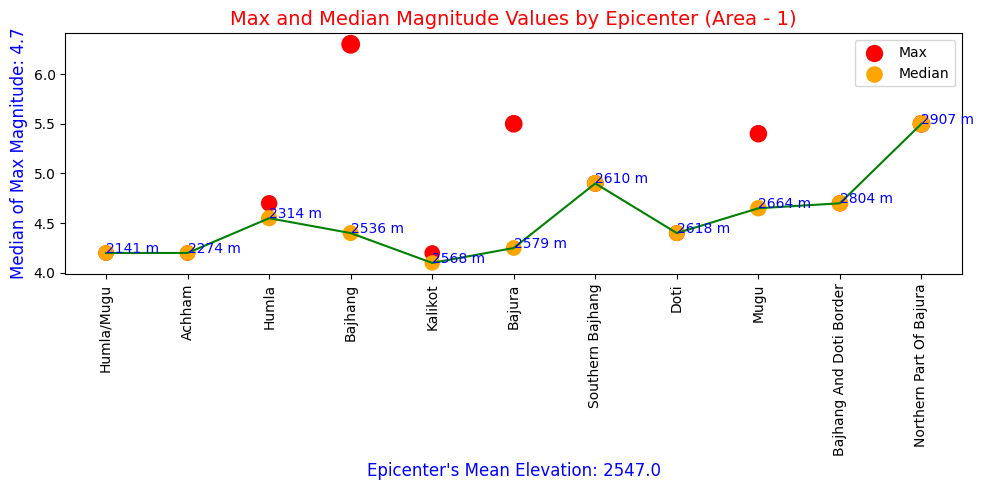

In [62]:
plt.figure(figsize = (10, 5))

elevation_val = far_zone.groupby(["Epicenter"])["Elevation"].mean().sort_values()

max_val = far_zone.groupby(["Epicenter"])["Magnitude"].max()
max_val = max_val.loc[elevation_val.index]

median_val = far_zone.groupby(["Epicenter"])["Magnitude"].median()
median_val = median_val.loc[elevation_val.index]

max_size = max_val.values * 25
median_size = median_val.values * 25

plt.scatter(max_val.index, max_val.values, color = "red", label = "Max", s = max_size)
plt.scatter(median_val.index, median_val.values, color = "orange", label = "Median", s = median_size)

plt.plot(median_val.index, median_val.values, color = "green")
for epicenter, median, elevation in zip(median_val.index, 
                                        median_val.values, 
                                        elevation_val.values):
    plt.text(epicenter, median, s = str(int(round(elevation,0)))+" m", color = "blue")


plt.xlabel(f"Epicenter's Mean Elevation: {np.round(np.mean(elevation_val.mean()),0)}", fontsize = 12, color = "blue")
plt.ylabel(f"Median of Max Magnitude: {np.round(np.median(max_val),2)}", fontsize = 12, color = "blue")
plt.title("Max and Median Magnitude Values by Epicenter (Area - 1)", fontsize = 14, color = "red")
plt.xticks(rotation = 90)
plt.legend(loc = "best")
plt.tight_layout()
plt.savefig("./max-median-graph-area1.jpg", 
            bbox_inches = "tight", 
            pad_inches = 0.1)
plt.show()

* Regions including Achham, Bajhang, Doti Border, Doti, Humla/Mugu, the Northern Part of Bajura, and Southern Bajhang show no significant difference between maximum and median seismic intensity levels.

* Bajhang stands out with a median intensity of approximately 4.5, considered insignificant, yet experienced the most powerful earthquake with a magnitude of around 6.5.

* This highlights the complexity of predicting seismic events solely based on historical magnitude data and elevation.

* Higher-altitude epicenters do show a pattern in median values, suggesting a potential correlation with higher-magnitude earthquakes.

* The top three locations posing the highest seismic risk are identified as Bajhang (Northern Part), Bajura, and Mugu.

#### Understanding Pattern in Area -2

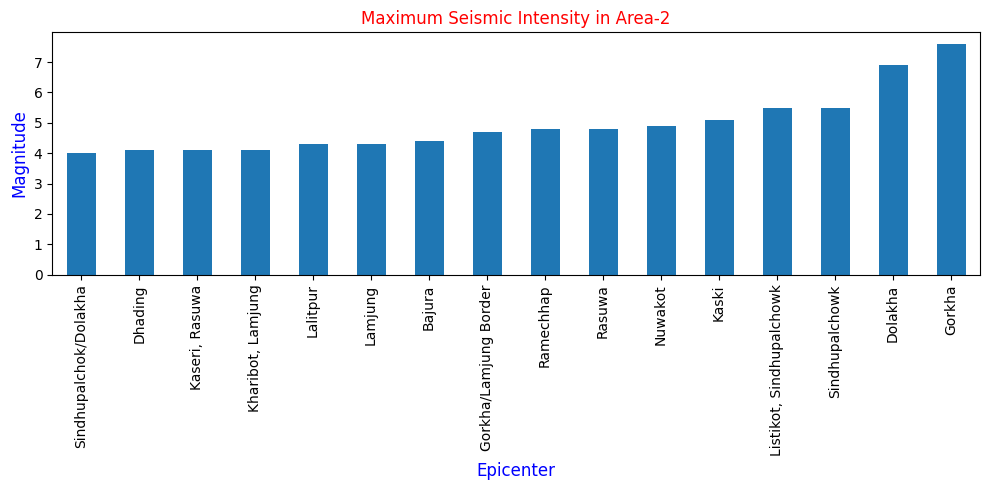

In [63]:
plt.figure(figsize = (10, 5))
central_zone.groupby(["Epicenter"])["Magnitude"].max().sort_values().plot(kind = "bar")
plt.title("Maximum Seismic Intensity in Area-2", fontsize = 12, color = "red")
plt.xlabel("Epicenter", color = "blue", fontsize = 12)
plt.ylabel("Magnitude", color = "blue", fontsize = 12)
plt.tight_layout()
plt.savefig("max-intensity-area2.jpg", bbox_inches = "tight", pad_inches = 0.1)
plt.show()

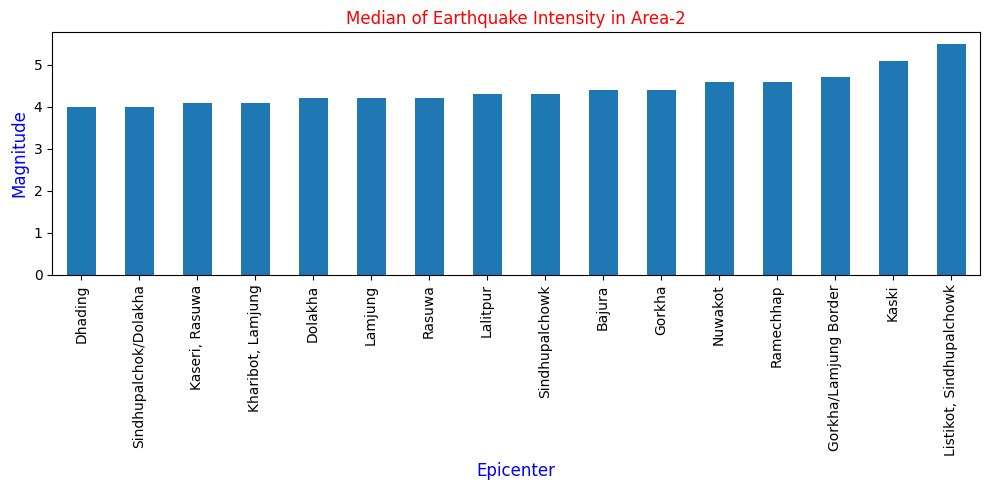

In [64]:
plt.figure(figsize = (10, 5))
central_zone.groupby(["Epicenter"])["Magnitude"].median().sort_values().plot(kind = "bar")
plt.title("Median of Earthquake Intensity in Area-2", fontsize = 12, color = "red")
plt.xlabel("Epicenter", color = "blue", fontsize = 12)
plt.ylabel("Magnitude", color = "blue", fontsize = 12)
plt.tight_layout()
plt.savefig("./median-intensity-area2.jpg", bbox_inches = "tight", pad_inches = 0.1)
plt.show()

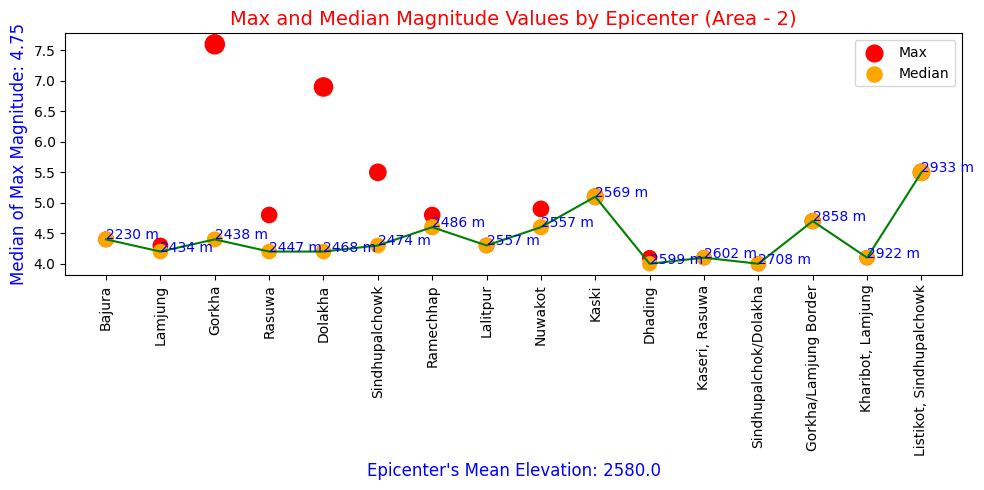

In [65]:
plt.figure(figsize = (10, 5))

elevation_val = central_zone.groupby(["Epicenter"])["Elevation"].mean().sort_values()

max_val = central_zone.groupby(["Epicenter"])["Magnitude"].max()
max_val = max_val.loc[elevation_val.index]

median_val = central_zone.groupby(["Epicenter"])["Magnitude"].median()
median_val = median_val.loc[elevation_val.index]

max_size = max_val.values * 25
median_size = median_val.values * 25

plt.scatter(max_val.index, max_val.values, color = "red", label = "Max", s = max_size)
plt.scatter(median_val.index, median_val.values, color = "orange", label = "Median", s = median_size)

plt.plot(median_val.index, median_val.values, color = "green")
for epicenter, median, elevation in zip(median_val.index, 
                                        median_val.values, 
                                        elevation_val.values):
    plt.text(epicenter, median, s = str(int(round(elevation,0)))+" m", color = "blue")


plt.xlabel(f"Epicenter's Mean Elevation: {np.round(np.mean(elevation_val.values),0)}", fontsize = 12, color = "blue")
plt.ylabel(f"Median of Max Magnitude: {np.round(max_val.median(),2)}", fontsize = 12, color = "blue")
plt.title("Max and Median Magnitude Values by Epicenter (Area - 2)", fontsize = 14, color = "red")
plt.xticks(rotation = 90)
plt.legend(loc = "best")
plt.tight_layout()
plt.savefig("./max-median-graph-area2.jpg", bbox_inches = "tight", pad_inches = 0.1)
plt.show()

* Despite having relatively moderate median values on the seismic scale, Gorkha and Dolakha have experienced the most powerful earthquakes.

* Listikot in Sindhupalchowk exhibits the highest median intensity, surpassing the maximum intensity recorded in some other regions.

* This suggests that Listikot, Sindhupalchowk, is particularly susceptible to intense seismic events, as evidenced by its consistently high seismic magnitude.

* The top three regions identified as having the highest seismic risk are Gorkha, Dolakha, and Sindhupalchowk.

**Presence of Places in Area - 1 and Area -2 as Maximum Flucutating Seismic Activity**

In [66]:
fluctuation = {"far_zone": [], "central_zone": []}
for idx in data.nlargest(15).index:
    if idx in far_zone["Epicenter"].values:
        fluctuation["far_zone"].append(idx)
    elif idx in central_zone["Epicenter"].values:
        fluctuation["central_zone"].append(idx)
    else:
        continue
        
count = 0
included = [count+len(val) for key, val in fluctuation.items()]
included = included[0] + included[1]

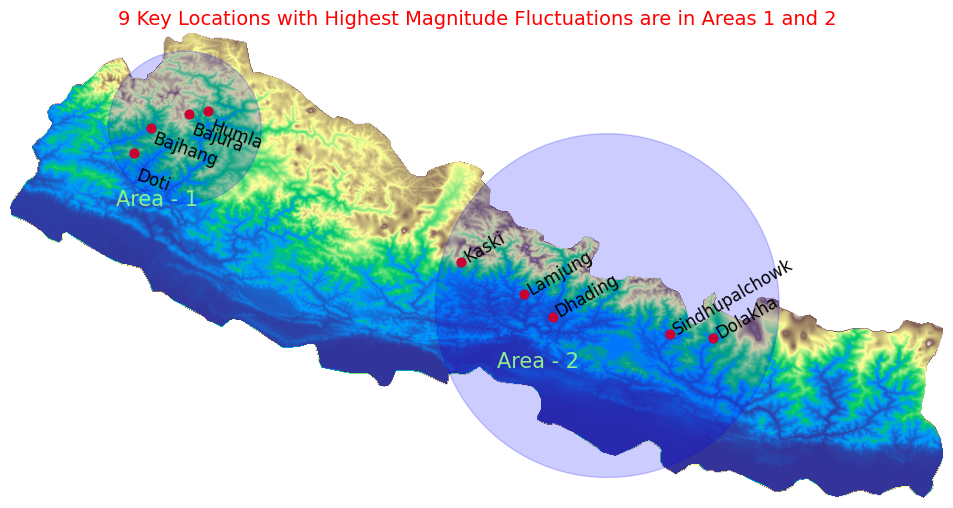

In [67]:
fig, ax = plt.subplots(figsize = (10,6))
ax.imshow(nepal_topography[0], cmap = "terrain")
for key, val in fluctuation.items():
    for place in val:
        lat, long = places_in_nepal[places_in_nepal["Epicenter"]==place].iloc[0]["Latitute"], places_in_nepal[places_in_nepal["Epicenter"]==place].iloc[0]["Longitude"]
        col, row = rasterio.transform.rowcol(clipped_transform, long, lat)
        ax.scatter(row, col, s = 40, color = "red")
        if place not in far_zone["Epicenter"].unique():
            plt.text(row, col, place, rotation = 30, color = "black", fontsize = 12)
        else:
            plt.text(row, col+40, place, rotation = -20, color = "black", fontsize = 12)

circle = plt.Circle((625, 285), radius = 180, fill = True, alpha = 0.2, color = "blue")
ax.add_patch(circle)

circle = plt.Circle((182.5, 98.5),radius = 80, fill = True, alpha = 0.2, color = "blue")
ax.add_patch(circle)

plt.text(x = 110, y = 180, s = "Area - 1", color = "lightgreen",fontsize = 15)
plt.text(x = 510, y = 350, s = "Area - 2", color = "lightgreen", fontsize = 15)

plt.title(f"{included} Key Locations with Highest Magnitude Fluctuations are in Areas 1 and 2", fontsize = 14, color = "red")
plt.tight_layout()
plt.axis("off")
plt.savefig("./key-location.jpg")
plt.show()

## Earthquake Timeline

In [68]:
timeline = earthquake_df_new.nlargest(n = 20, columns = "Magnitude").groupby(["Year", "Epicenter"])["Magnitude"].median().unstack().replace(np.nan, 0)
timeline.drop(["Bhuj/India", "Tibet"], axis = 1, inplace = True)
timeline.head()

Epicenter  Bajhang  Bajura  Dhading  Dolakha  Doti  Gorkha  Humla  Jajarkot  Khotang  Sindhupalchok/Tibet  Sindhupalchowk  Taplejung-Sikkim Border
Year                                                                                                                                              
2001           0.0     0.0      0.0      0.0   0.0     0.0    0.0       0.0      0.0                  0.0             0.0                      0.0
2002           0.0     0.0      0.0      0.0   0.0     0.0    0.0       0.0      0.0                  0.0             0.0                      0.0
2008           0.0     0.0      0.0      0.0   0.0     0.0    6.0       0.0      0.0                  0.0             0.0                      0.0
2011           0.0     0.0      0.0      0.0   0.0     0.0    0.0       0.0      0.0                  0.0             0.0                      6.8
2013           0.0     0.0      0.0      0.0   0.0     0.0    0.0       0.0      0.0                  0.0             0.0                      0.0

In [69]:
timeline_count = earthquake_df_new.nlargest(n = 20, columns = "Magnitude").groupby(["Epicenter"])["Epicenter"].count()
timeline_count

Epicenter
Bajhang                    1
Bajura                     2
Bhuj/India                 1
Dhading                    2
Dolakha                    3
Doti                       1
Gorkha                     2
Humla                      1
Jajarkot                   1
Khotang                    1
Sindhupalchok/Tibet        1
Sindhupalchowk             1
Taplejung-Sikkim Border    1
Tibet                      2
Name: Epicenter, dtype: int64

/tmp/ipykernel_20/2432963247.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap("plasma", len(timeline.columns))


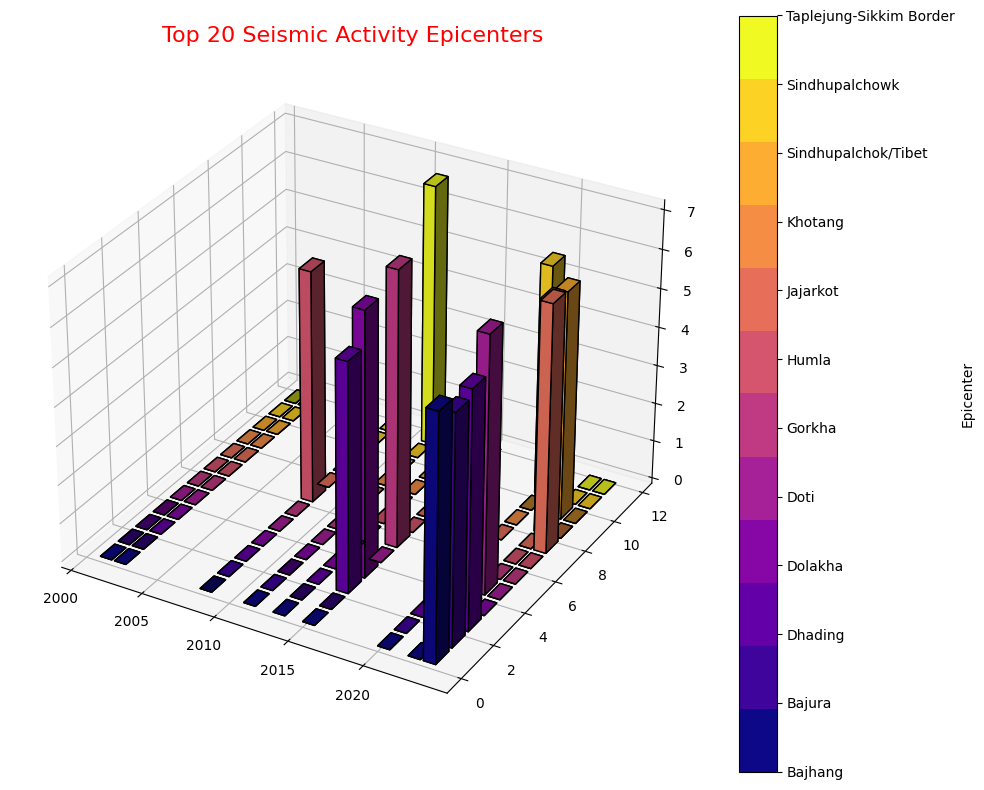

In [70]:
years = timeline.index
epicenters = np.arange(len(timeline.columns))

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection = "3d")

X, Y = np.meshgrid(years, epicenters)

Z = timeline.to_numpy().T

colormap = plt.cm.get_cmap("plasma", len(timeline.columns))

for i, epi in enumerate(epicenters):
    color = colormap(i)
    ax.bar3d(X[i, :].flatten(), 
             Y[i, :].flatten(), 0, 0.8, 0.8, 
             Z[i, :].flatten(), shade = True, 
             color = color, edgecolor = "black")
    


mappable = plt.cm.ScalarMappable(cmap=colormap)
mappable.set_array(epicenters)
mappable.set_clim(epicenters.min(), epicenters.max())

cbar = plt.colorbar(mappable, ax = ax)
cbar.set_label('Epicenter')

cbar.set_ticks(ticks = epicenters, labels = timeline.columns)
plt.tight_layout()
plt.title("Top 20 Seismic Activity Epicenters", fontsize = 16, color = "red")
plt.savefig("./max-mag-epicenters.jpg")
plt.show()

* **Highest Magnitude: Taplejung-Sikkim Border**

